# ML Greop Project: Online News Popularity
#### Group members: Ethan Lu 14724235, Grace Chang 14820056, Chi Kit Tin 14711079

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.cluster import hierarchy
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import LinearSVC
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN


In [ ]:
SVC_pipe = Pipeline([("Scaler", "passthrough"),  ("Classifier", LinearSVC(dual=False, max_iter=5000)) ])

## 1. Understanding the dataset 

In [3]:
news_pop = pd.read_csv('/Users/ethanlu/Desktop/Machine Learning/Final/ML Group Project Datasets/Online News Popularity/OnlineNewsPopularity/OnlineNewsPopularity.csv', sep=',')

news_pop.drop(['url'], axis=1, inplace=True)
news_pop.head()

timedelta   n_tokens_title   n_tokens_content   n_unique_tokens  \
0       731.0             12.0              219.0          0.663594   
1       731.0              9.0              255.0          0.604743   
2       731.0              9.0              211.0          0.575130   
3       731.0              9.0              531.0          0.503788   
4       731.0             13.0             1072.0          0.415646   

    n_non_stop_words   n_non_stop_unique_tokens   num_hrefs   num_self_hrefs  \
0                1.0                   0.815385         4.0              2.0   
1                1.0                   0.791946         3.0              1.0   
2                1.0                   0.663866         3.0              1.0   
3                1.0                   0.665635         9.0              0.0   
4                1.0                   0.540890        19.0             19.0   

    num_imgs   num_videos  ...   min_positive_polarity  \
0        1.0          0.0  ...                0.100000   
1        1.0          0.0  ...                0.033333   
2        1.0          0.0  ...                0.100000   
3        1.0          0.0  ...                0.136364   
4       20.0          0.0  ...                0.033333   

    max_positive_polarity   avg_negative_polarity   min_negative_polarity  \
0                     0.7               -0.350000                  -0.600   
1                     0.7               -0.118750                  -0.125   
2                     1.0               -0.466667                  -0.800   
3                     0.8               -0.369697                  -0.600   
4                     1.0               -0.220192                  -0.500   

    max_negative_polarity   title_subjectivity   title_sentiment_polarity  \
0               -0.200000             0.500000                  -0.187500   
1               -0.100000             0.000000                   0.000000   
2               -0.133333             0.000000                   0.000000   
3               -0.166667             0.000000                   0.000000   
4               -0.050000             0.454545                   0.136364   

    abs_title_subjectivity   abs_title_sentiment_polarity   shares  
0                 0.000000                       0.187500      593  
1                 0.500000                       0.000000      711  
2                 0.500000                       0.000000     1500  
3                 0.500000                       0.000000     1200  
4                 0.045455                       0.136364      505  

[5 rows x 60 columns]

**Descriptive Statistics**

In [5]:
print(news_pop.info())
print(news_pop.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 60 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0    timedelta                      39644 non-null  float64
 1    n_tokens_title                 39644 non-null  float64
 2    n_tokens_content               39644 non-null  float64
 3    n_unique_tokens                39644 non-null  float64
 4    n_non_stop_words               39644 non-null  float64
 5    n_non_stop_unique_tokens       39644 non-null  float64
 6    num_hrefs                      39644 non-null  float64
 7    num_self_hrefs                 39644 non-null  float64
 8    num_imgs                       39644 non-null  float64
 9    num_videos                     39644 non-null  float64
 10   average_token_length           39644 non-null  float64
 11   num_keywords                   39644 non-null  float64
 12   data_channel_is_lifestyle      

Check for duplicates:

In [6]:
print(news_pop.duplicated().sum())

0


**Feature Distributions**

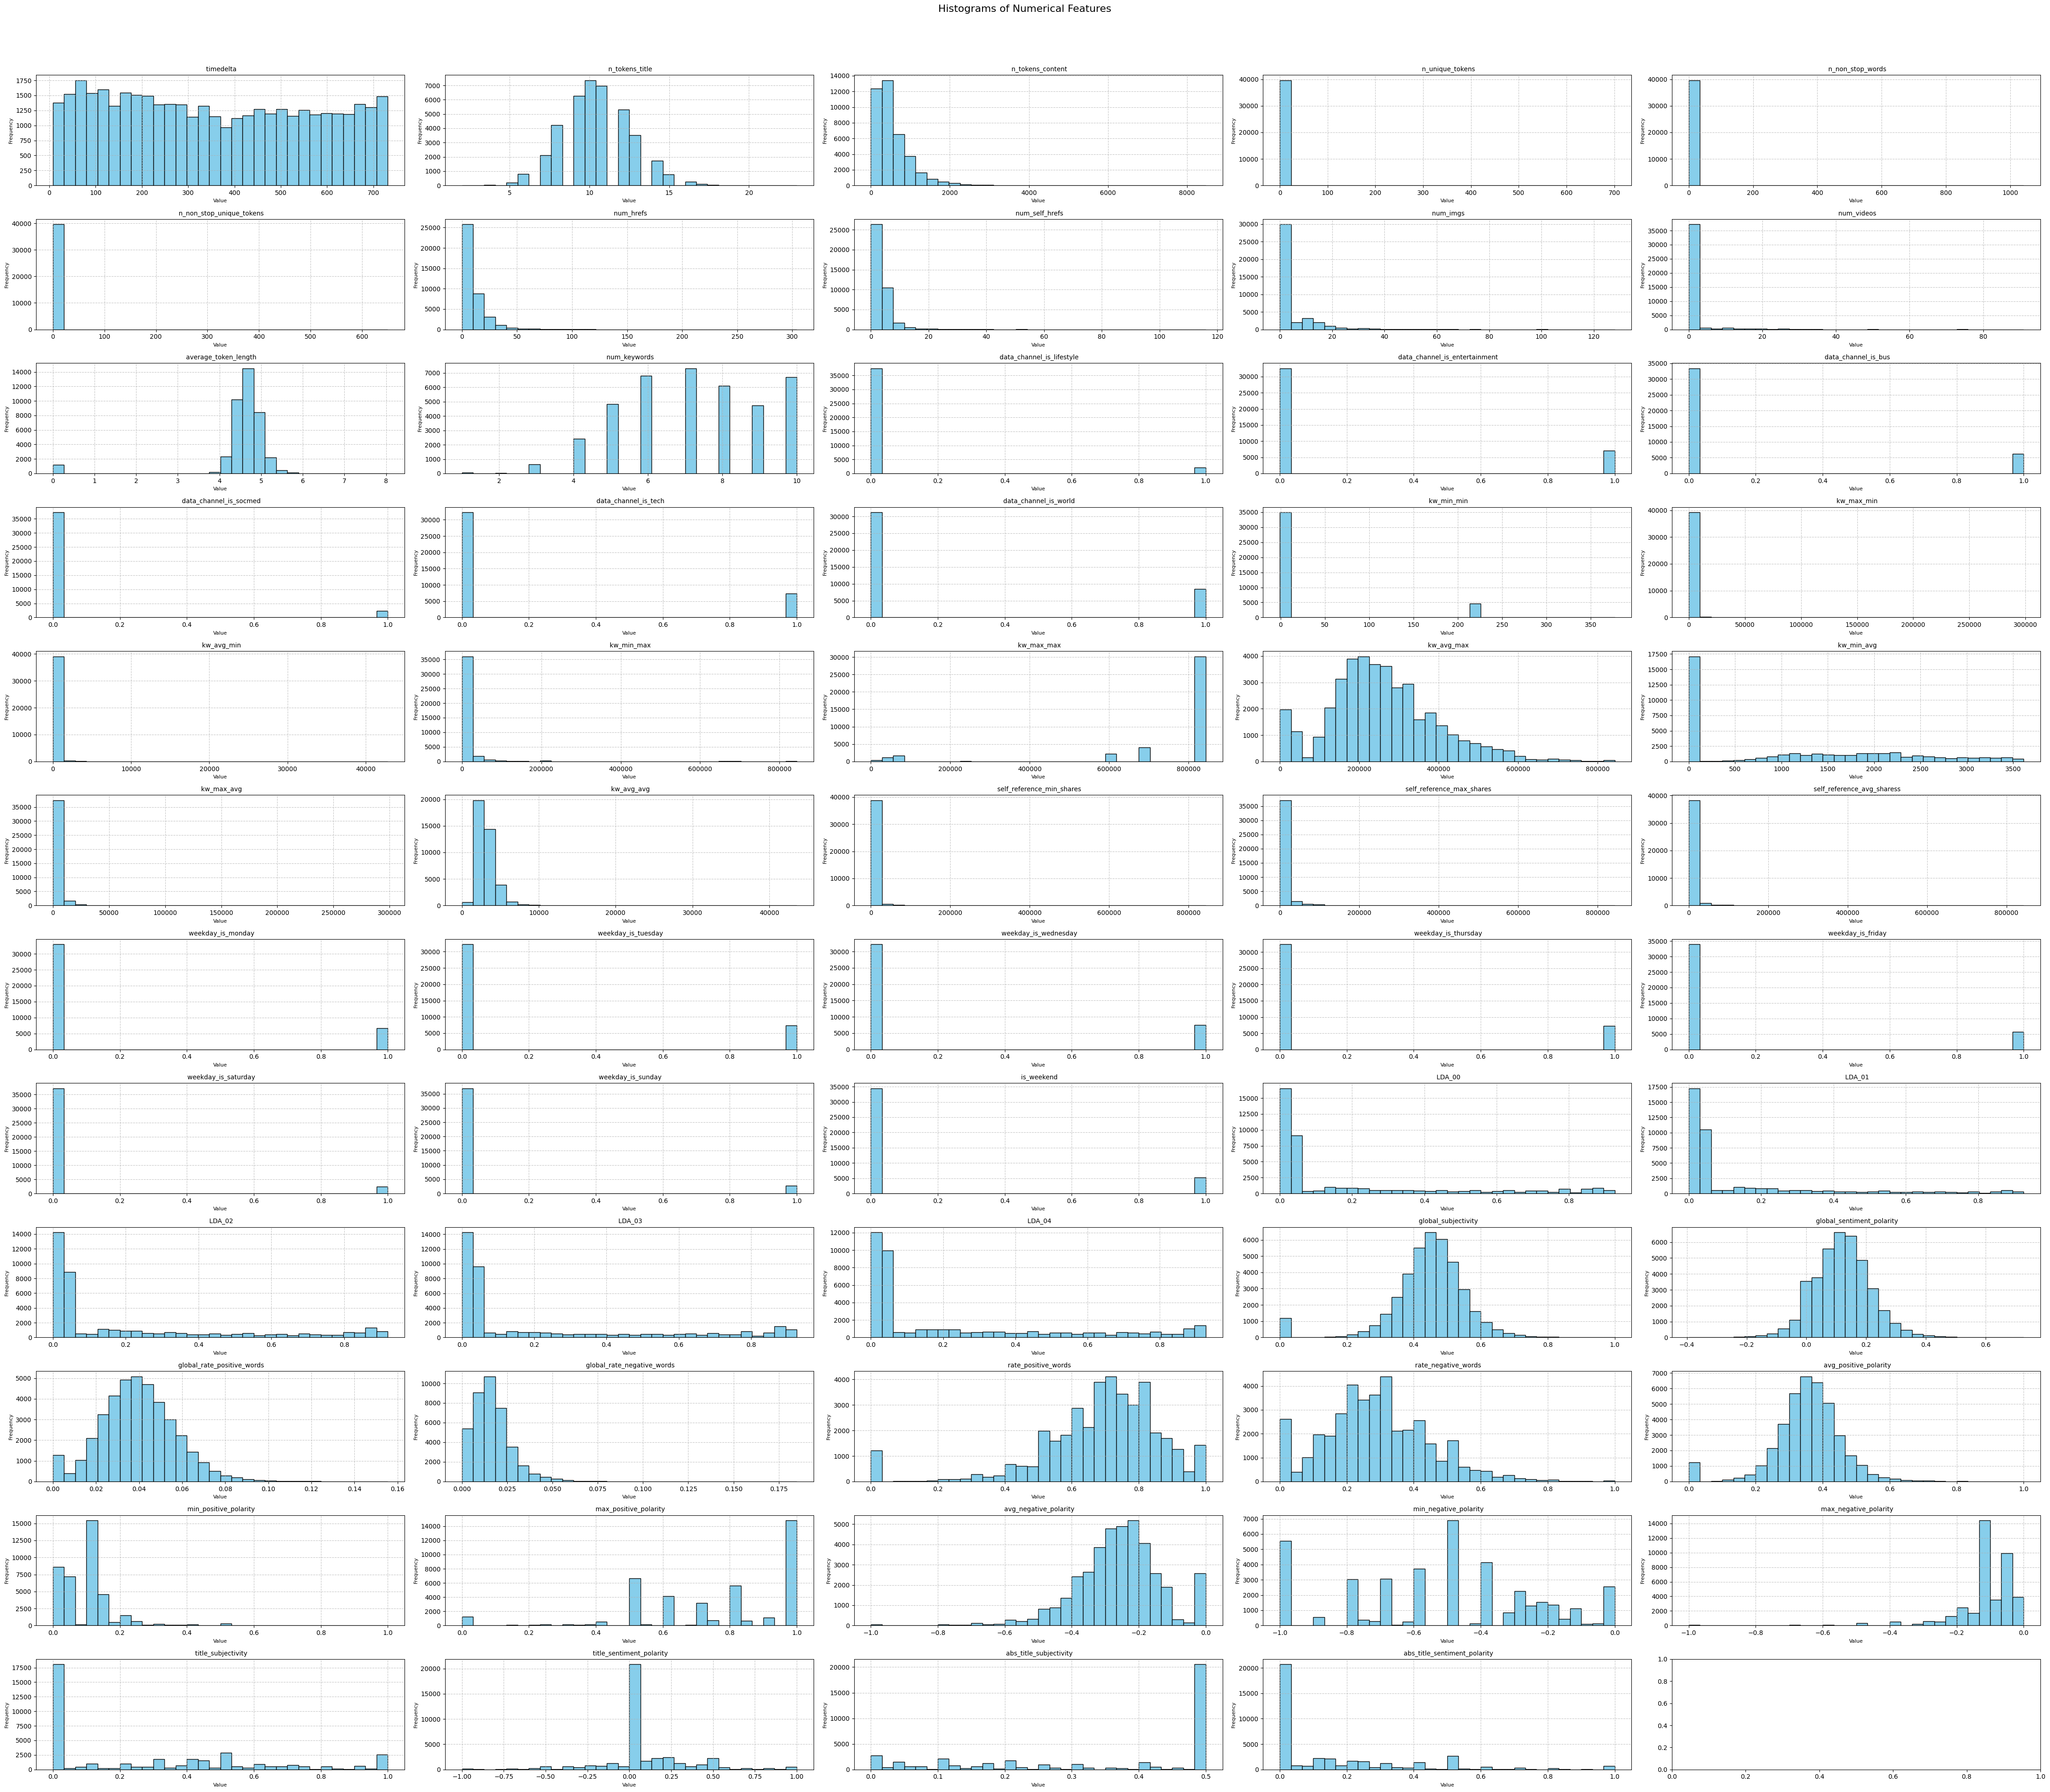

In [12]:
# Set the number of columns for subplots
num_cols = 5
num_features = len(news_pop.columns)
num_rows = int(np.ceil(num_features / num_cols))

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(45, 40))
axes = axes.flatten()  # Flatten the grid for easier indexing

# Plot each feature's histogram
for i, col in enumerate(news_pop.iloc[:,:-1].columns):
    ax = axes[i]
    ax.hist(news_pop[col], bins=30, color='skyblue', edgecolor='black')
    ax.set_title(col, fontsize=10)
    ax.set_xlabel('Value', fontsize=8)
    ax.set_ylabel('Frequency', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.7)


# Adjust spacing and add a main title
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.show()

**Target Distribution: Shares**

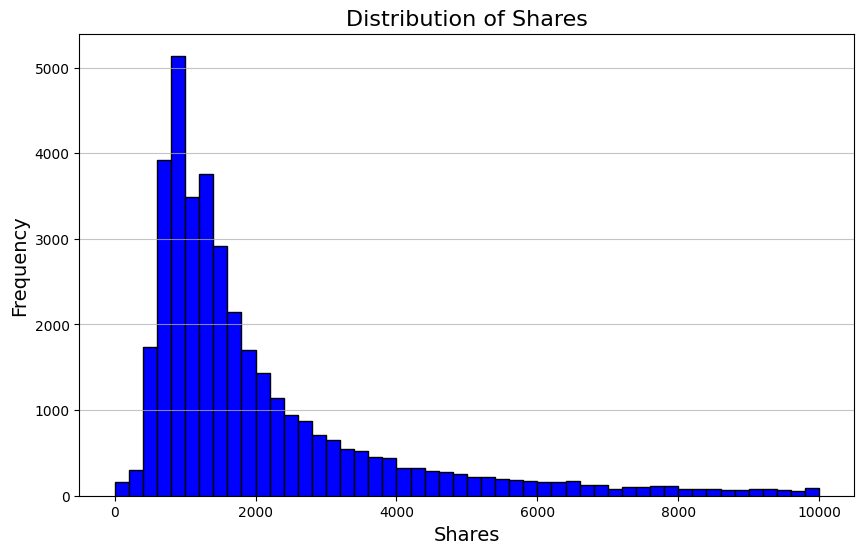

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(news_pop[' shares'], bins=50, color='blue', edgecolor='black', range=(0, 10000))  # Limit x-axis to 10,000 shares
plt.title('Distribution of Shares', fontsize=16)
plt.xlabel('Shares', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.show()


**Relationship between features and target**

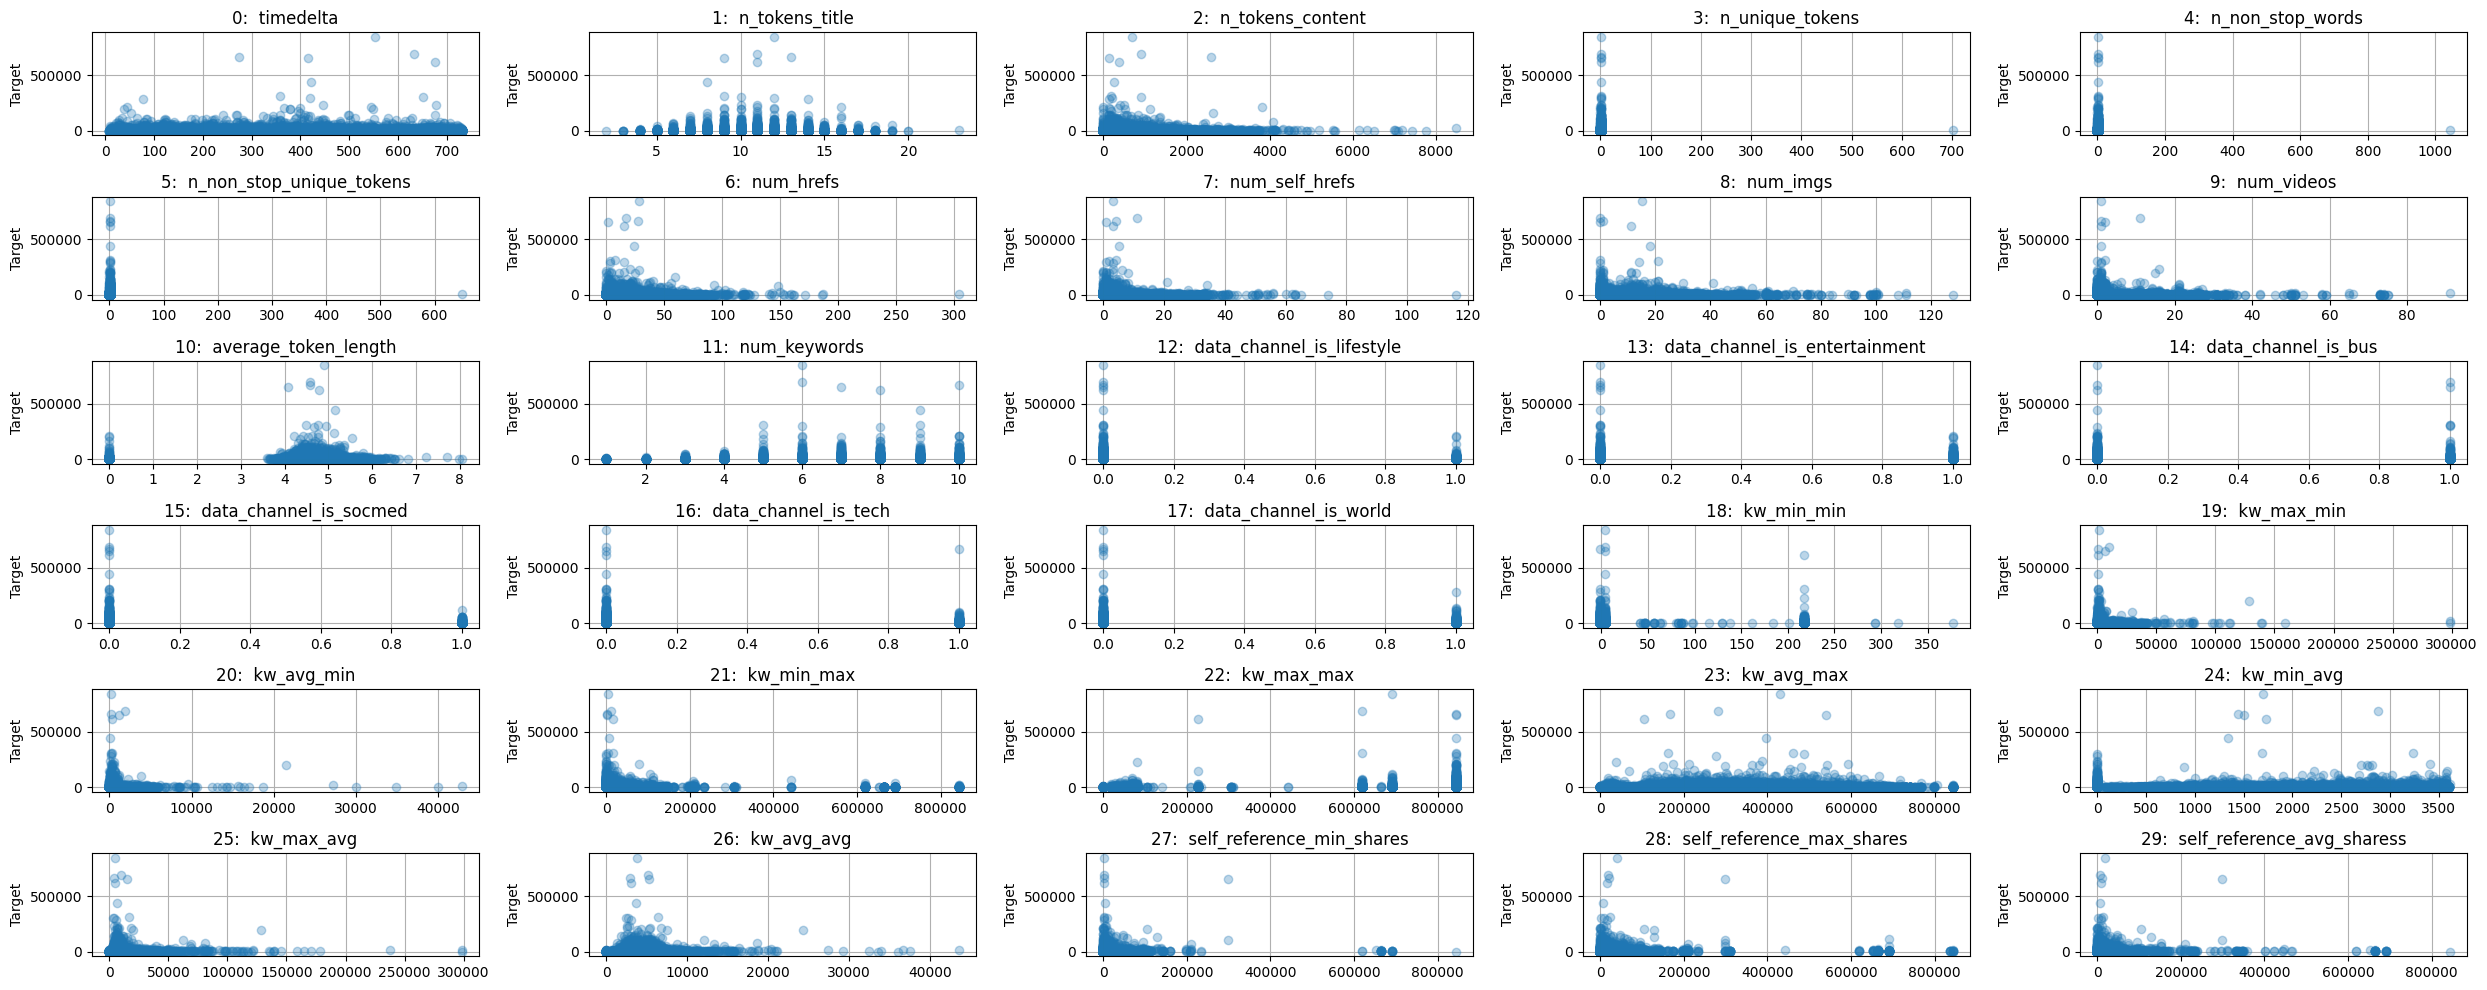

In [ ]:
# Create subplots
fig, axes = plt.subplots(6, 5, figsize=(25, 10 ))  # Adjust layout for the number of features
for i, ax in enumerate(axes.ravel()):
    if i >= len(news_pop.columns) - 1:  # Exclude the last column if it is the target
        ax.set_visible(False)
        continue
    # Plot feature vs target
    ax.plot(news_pop.iloc[:, i], news_pop.iloc[:, -1], 'o', alpha=0.3)
    ax.set_title(f"{i}: {news_pop.columns[i]}")
    ax.set_ylabel("Target")  # Replace with the actual target column name if known
    ax.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

**Correlation Analysis**

In [15]:
# Correlation Matrix
corr_matrix = news_pop.corr()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


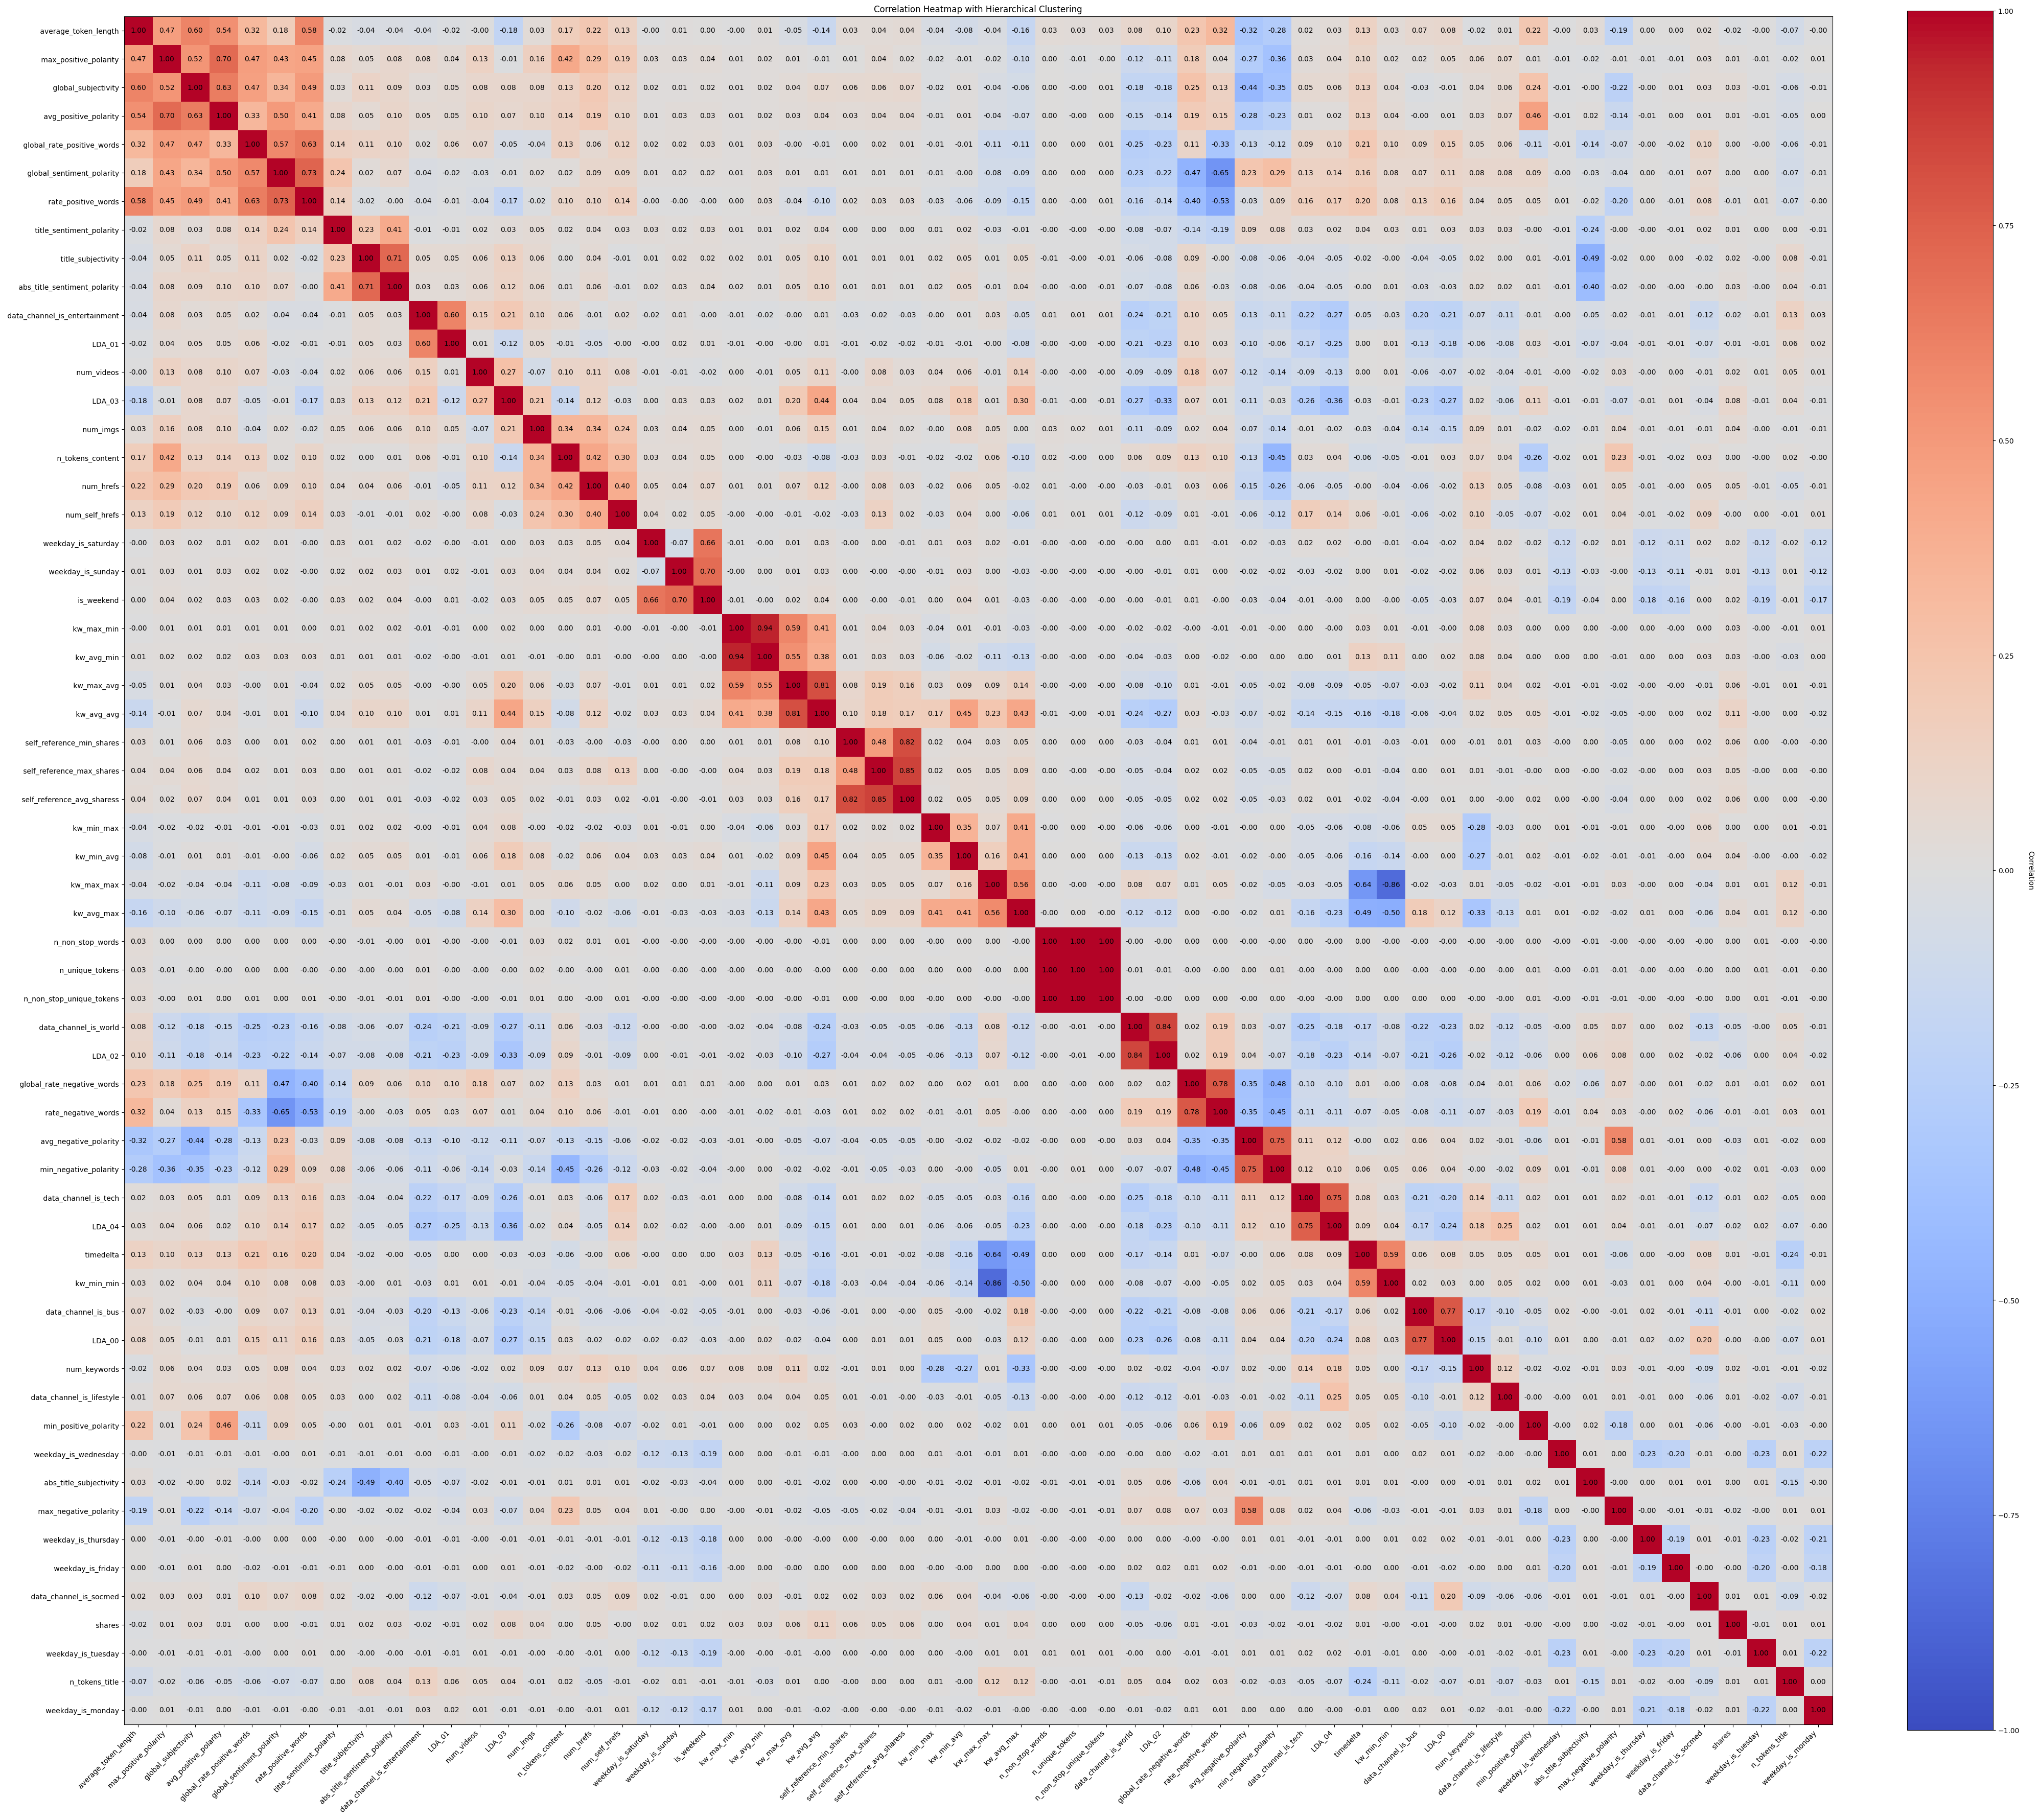

In [16]:
# Hierarchical clustering & get the order of features
order = np.array(hierarchy.dendrogram(
    hierarchy.ward(1 - corr_matrix), no_plot=True)['ivl'], dtype="int")

# Reorder the correlation matrix based on the clustering
reordered_corr = corr_matrix.iloc[order, order]

# Heatmap
plt.figure(figsize=(40, 40))

im = plt.imshow(reordered_corr, cmap="coolwarm", vmin=-1, vmax=1)  # Correlation range [-1, 1]
plt.xticks(range(len(reordered_corr.columns)), reordered_corr.columns, rotation=45, ha="right")
plt.yticks(range(len(reordered_corr.columns)), reordered_corr.columns)

cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Correlation', rotation=270, labelpad=20)

for i in range(len(reordered_corr.columns)):
    for j in range(len(reordered_corr.columns)):
        plt.text(j, i, f"{reordered_corr.iloc[i, j]:.2f}",
                 ha="center", va="center", color="black")

plt.tight_layout()
plt.title("Correlation Heatmap with Hierarchical Clustering")
plt.show()


In [17]:
# Correlation between features and target (V)
target_corr = corr_matrix[' shares']
print(target_corr.head(5))

 timedelta           0.008662
 n_tokens_title      0.008783
 n_tokens_content    0.002459
 n_unique_tokens     0.000806
 n_non_stop_words    0.000443
Name:  shares, dtype: float64


In [18]:
higher_correlated_features = target_corr[abs(target_corr) > 0.1].index
print("Features higher correlated to target:", higher_correlated_features)

Features higher correlated to target: Index([' kw_avg_avg', ' shares'], dtype='object')


## Advanced Feature Processing: Clustering

###  K-Means Clustering Attempt

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.1

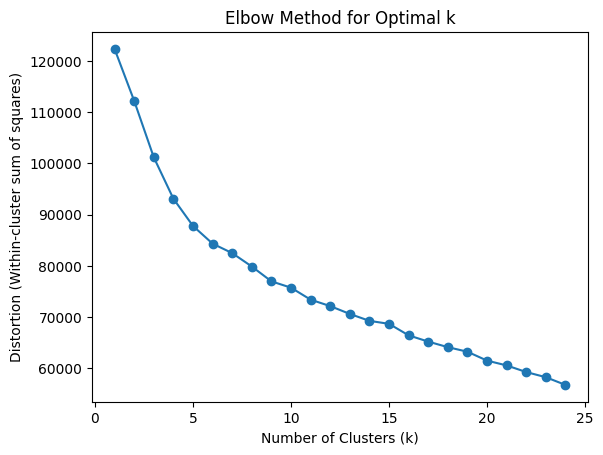

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


          timedelta   n_tokens_title   n_tokens_content   n_unique_tokens  \
Cluster                                                                     
0        335.713689        10.959098         636.097663          0.546993   
1        292.224215        10.452274         604.042921          0.513409   
2        377.896435        10.286927         506.309847          0.552986   
3        391.853774        10.128706         483.752695          0.577976   
4        379.112542        10.209492         552.654915          0.534618   
5        386.257539        10.317855         512.265199          0.553806   
6        287.840156        10.645874         607.679012          0.511305   
7        392.762480        10.306763         579.374396          0.530425   
8        432.338822         9.739709         612.955668          0.530981   
9        289.154188        10.427724         587.398073          0.517869   
10       351.970817        10.447471         700.569390          0.507118   

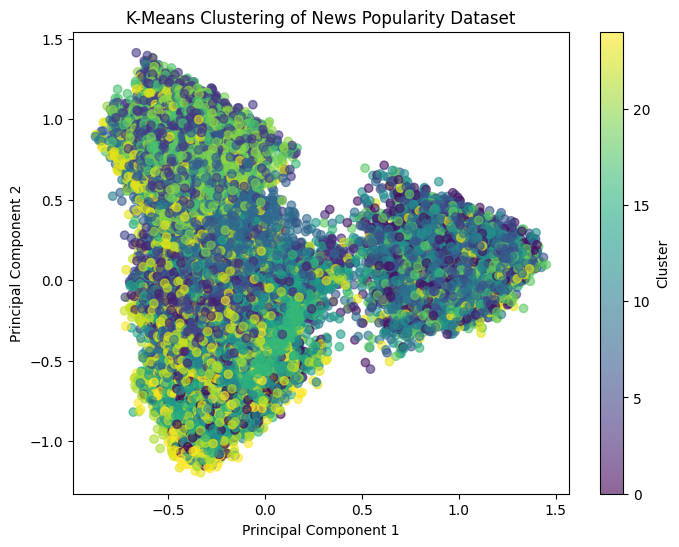

Cluster centers:
[[0.45326928 0.42662374 0.07506463 ... 0.64556902 0.1705913  0.00343519]
 [0.39311786 0.40248925 0.07128191 ... 0.7290075  0.11593366 0.00281448]
 [0.51161333 0.39461557 0.05974862 ... 0.7011132  0.13886002 0.00347747]
 ...
 [0.50940455 0.39236958 0.0652378  ... 0.67416796 0.13253425 0.00463018]
 [0.47629519 0.39418988 0.07402161 ... 0.66351391 0.16747778 0.00480355]
 [0.50919827 0.40072428 0.06063921 ... 0.60180073 0.21992059 0.00496696]]


In [19]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X = news_pop # Drop any non-numeric columns if necessary

# Scale the data using MinMaxScaler (or StandardScaler)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


from sklearn.cluster import KMeans

# Elbow method to determine the optimal number of clusters
distortions = []
for k in range(1, 25):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    distortions.append(kmeans.inertia_)

plt.plot(range(1,25), distortions, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distortion (Within-cluster sum of squares)")
plt.show()


# Apply KMeans with 3 clusters (chosen from elbow/silhouette analysis)
kmeans = KMeans(n_clusters=25, random_state=42)
kmeans.fit(X_scaled)

# Add the cluster labels to the original data
news_pop['Cluster'] = kmeans.labels_

# Inspect the clusters
print(news_pop.groupby('Cluster').mean())  # Find the average values of each feature in each cluster

# For 2D visualization, you can use PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.6)
plt.title("K-Means Clustering of News Popularity Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster')
plt.show()

print("Cluster centers:")
print(kmeans.cluster_centers_)


### DBSCAN (Density-Based Spatial Clustering of Applications with Noise) 

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
import seaborn as sns

# Assuming 'news_pop' is your dataset (replace with your actual dataset if necessary)
X = news_pop # Drop any non-numeric columns like 'url'

# Step 1: Apply Min-Max Scaling (scales data to the range [0, 1])
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply DBSCAN
# Adjust eps and min_samples according to your dataset characteristics
dbscan = DBSCAN(eps=0.0002, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

# Add the cluster labels to the original data
news_pop['Cluster'] = clusters



# Step 4: Analyze the clustering results
# Group by clusters and calculate the mean of the features within each cluster
cluster_means = news_pop.groupby('Cluster').mean()
print(cluster_means)

# You can also identify noise points (labelled as -1 by DBSCAN)
noise_points = news_pop[news_pop['Cluster'] == -1]
print("Noise points (outliers):")
print(noise_points)

# Identify noise points (those with cluster label -1)
noise_points = news_pop[news_pop['Cluster'] == -1]

# Print the number of noise points
print(f"Number of noise points: {len(noise_points)}")

# Optionally, print the noise points if needed
# print(noise_points)

          timedelta   n_tokens_title   n_tokens_content   n_unique_tokens  \
Cluster                                                                     
-1       354.530471        10.398749         546.514731          0.548216   

          n_non_stop_words   n_non_stop_unique_tokens   num_hrefs  \
Cluster                                                             
-1                0.996469                   0.689175    10.88369   

          num_self_hrefs   num_imgs   num_videos  ...   min_positive_polarity  \
Cluster                                           ...                           
-1              3.293638   4.544143     1.249874  ...                0.095446   

          max_positive_polarity   avg_negative_polarity  \
Cluster                                                   
-1                     0.756728               -0.259524   

          min_negative_polarity   max_negative_polarity   title_subjectivity  \
Cluster                                                   

## Model building

### Define X and y

In [21]:
median_threshold = news_pop[' shares'].median()
percentile_75_threshold = news_pop[' shares'].quantile(0.75)

print(f"Median Threshold: {median_threshold}")
print(f"75th Percentile Threshold: {percentile_75_threshold}")

# Create a new column 'pop_level' on copied form based on the popularity threshold
news_pop_copy = news_pop.copy()
news_pop_copy['pop_level'] = news_pop_copy[' shares'].apply(lambda x: 'Popular' if x >= 1400 else 'Not Popular')

from sklearn.model_selection import train_test_split

x = news_pop.drop([' shares','Cluster'], axis=1)

y = news_pop_copy['pop_level']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Count the number of "Popular" and "Not Popular" entries
popularity_counts = news_pop_copy['pop_level'].value_counts()
print(popularity_counts)

Median Threshold: 1400.0
75th Percentile Threshold: 2800.0
pop_level
Popular        21154
Not Popular    18490
Name: count, dtype: int64


### 3.1 Using Original data to fit classifiers:
1. LinearSVC
2. Logitic Regression
3. Random Forest

#### LinearSVC Using Original data

In [22]:
SVC_pipe = Pipeline([("Scaler", "passthrough"),  ("Classifier", LinearSVC(dual=False, max_iter=5000)) ])

param_grid_SVC = {
    "Scaler": [StandardScaler(), MinMaxScaler(),'passthrough'],
    "Classifier__C": np.logspace(-6, 6, num=13) }

grid = GridSearchCV(SVC_pipe, param_grid_SVC, cv=10, n_jobs=-1)
grid.fit(x_train, y_train)

# GridSeachCV results
results = pd.DataFrame(grid.cv_results_)

from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix

# Best Parameters for the Best Estimator
print("\nBest Parameters:", grid.best_params_)
print("Best Estimator:", grid.best_estimator_)

# Accuracy 
print("Training Score (accuracy) of Best Estimator):{:.4f}".format(grid.best_score_))
print("Test Score (accuracy) of Best Estimator :{:.4f}".format(grid.score(x_test, y_test)))

# Fit the best estimator to the all training data
best_estimator_SVC = grid.best_estimator_.fit(x_train, y_train)

print("\n=== Evaluation: LinearSVC with Original Data ===")
# Confusion Matrix
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, best_estimator_SVC.predict(x_test))))

# Macro-average Precision and Recall & F1-score
print("Classification report:\n{}".format(classification_report(y_test, best_estimator_SVC.predict(x_test))))

# Micro-average precision, recall
micro_precision = precision_score(y_test, best_estimator_SVC.predict(x_test), average='micro')
micro_recall = recall_score(y_test, best_estimator_SVC.predict(x_test), average='micro')

print("Micro-average Precision: {:.4f}".format(micro_precision))
print("Micro-average Recall: {:.4f}".format(micro_recall))


Best Parameters: {'Classifier__C': 1.0, 'Scaler': StandardScaler()}
Best Estimator: Pipeline(steps=[('Scaler', StandardScaler()),
                ('Classifier', LinearSVC(dual=False, max_iter=5000))])
Training Score (accuracy) of Best Estimator):0.6538
Test Score (accuracy) of Best Estimator :0.6525

=== Evaluation: LinearSVC with Original Data ===
Confusion matrix:
[[2281 1493]
 [1262 2893]]
Classification report:
              precision    recall  f1-score   support

 Not Popular       0.64      0.60      0.62      3774
     Popular       0.66      0.70      0.68      4155

    accuracy                           0.65      7929
   macro avg       0.65      0.65      0.65      7929
weighted avg       0.65      0.65      0.65      7929

Micro-average Precision: 0.6525
Micro-average Recall: 0.6525


#### Logistic Regression Using Original data

In [23]:
logreg_pipeline = make_pipeline(StandardScaler(), LogisticRegression(dual=False, solver='saga', max_iter=5000))

logreg_param_grid = {'standardscaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
                     'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

# Perform GridSearchCV
grid_original = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=5, n_jobs=-1)
grid_original.fit(x_train, y_train)

# Print results for the original data
print("\n=== Logistic Regression with Original Data ===")
print("Best Parameters:", grid_original.best_params_)
print("Best Cross-Validation Score:", grid_original.best_score_)

# Best model from original data
best_model_original = grid_original.best_estimator_
y_pred_original = best_model_original.predict(x_test)

print("\n=== Evaluation: Logistic Regression with Original Data ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_original))
print("Classification Report:\n", classification_report(y_test, y_pred_original))
# Micro-average precision, recall
micro_precision = precision_score(y_test, y_pred_original, average='micro')
micro_recall = recall_score(y_test, y_pred_original, average='micro')

print("Micro-average Precision: {:.4f}".format(micro_precision))
print("Micro-average Recall: {:.4f}".format(micro_recall))



=== Logistic Regression with Original Data ===
Best Parameters: {'logisticregression__C': 1, 'standardscaler': StandardScaler()}
Best Cross-Validation Score: 0.654106889484471

=== Evaluation: Logistic Regression with Original Data ===
Confusion Matrix:
 [[2261 1513]
 [1245 2910]]
Classification Report:
               precision    recall  f1-score   support

 Not Popular       0.64      0.60      0.62      3774
     Popular       0.66      0.70      0.68      4155

    accuracy                           0.65      7929
   macro avg       0.65      0.65      0.65      7929
weighted avg       0.65      0.65      0.65      7929

Micro-average Precision: 0.6522
Micro-average Recall: 0.6522


#### Random Forest Using Original data

In [41]:
pipeline_rf = Pipeline([
    ('scaler', 'passthrough'),
    ('classifier', RandomForestClassifier(random_state=42))])

# Parameter grid
param_grid_rf = {
    'classifier__n_estimators': [5, 10, 50, 100],  
    'classifier__max_depth': [5, 10, 20],
    'classifier__max_features': ['sqrt', 'log2']}

grid_org = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_org.fit(x_train, y_train)


# Best parameters and scores
print("Best Parameters:", grid_org.best_params_)
print("Best Cross-Validation Accuracy:", grid_org.best_score_)

# Evaluatation
test_score = grid_org.score(x_test, y_test)
print("Test Accuracy:", test_score)

# Predict on the test set
y_test_pred_rf_orig = grid_org.best_estimator_.predict(x_test)


print("\n=== Evaluation: Random Forest with Original Data ===")
# Confusion Matrix
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, y_test_pred_rf_orig)))
# Generate a classification report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_test_pred_rf_orig))

# Micro-average precision, recall
micro_precision = precision_score(y_test, y_test_pred_rf_orig, average='micro')
micro_recall = recall_score(y_test, y_test_pred_rf_orig, average='micro')

print("Micro-average Precision: {:.4f}".format(micro_precision))
print("Micro-average Recall: {:.4f}".format(micro_recall))



Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 100}
Best Cross-Validation Accuracy: 0.6685480056755478
Test Accuracy: 0.6674233825198638

=== Evaluation: Random Forest with Original Data ===
Confusion matrix:
[[2190 1584]
 [1053 3102]]

=== Classification Report ===
              precision    recall  f1-score   support

 Not Popular       0.68      0.58      0.62      3774
     Popular       0.66      0.75      0.70      4155

    accuracy                           0.67      7929
   macro avg       0.67      0.66      0.66      7929
weighted avg       0.67      0.67      0.66      7929

Micro-average Precision: 0.6674
Micro-average Recall: 0.6674


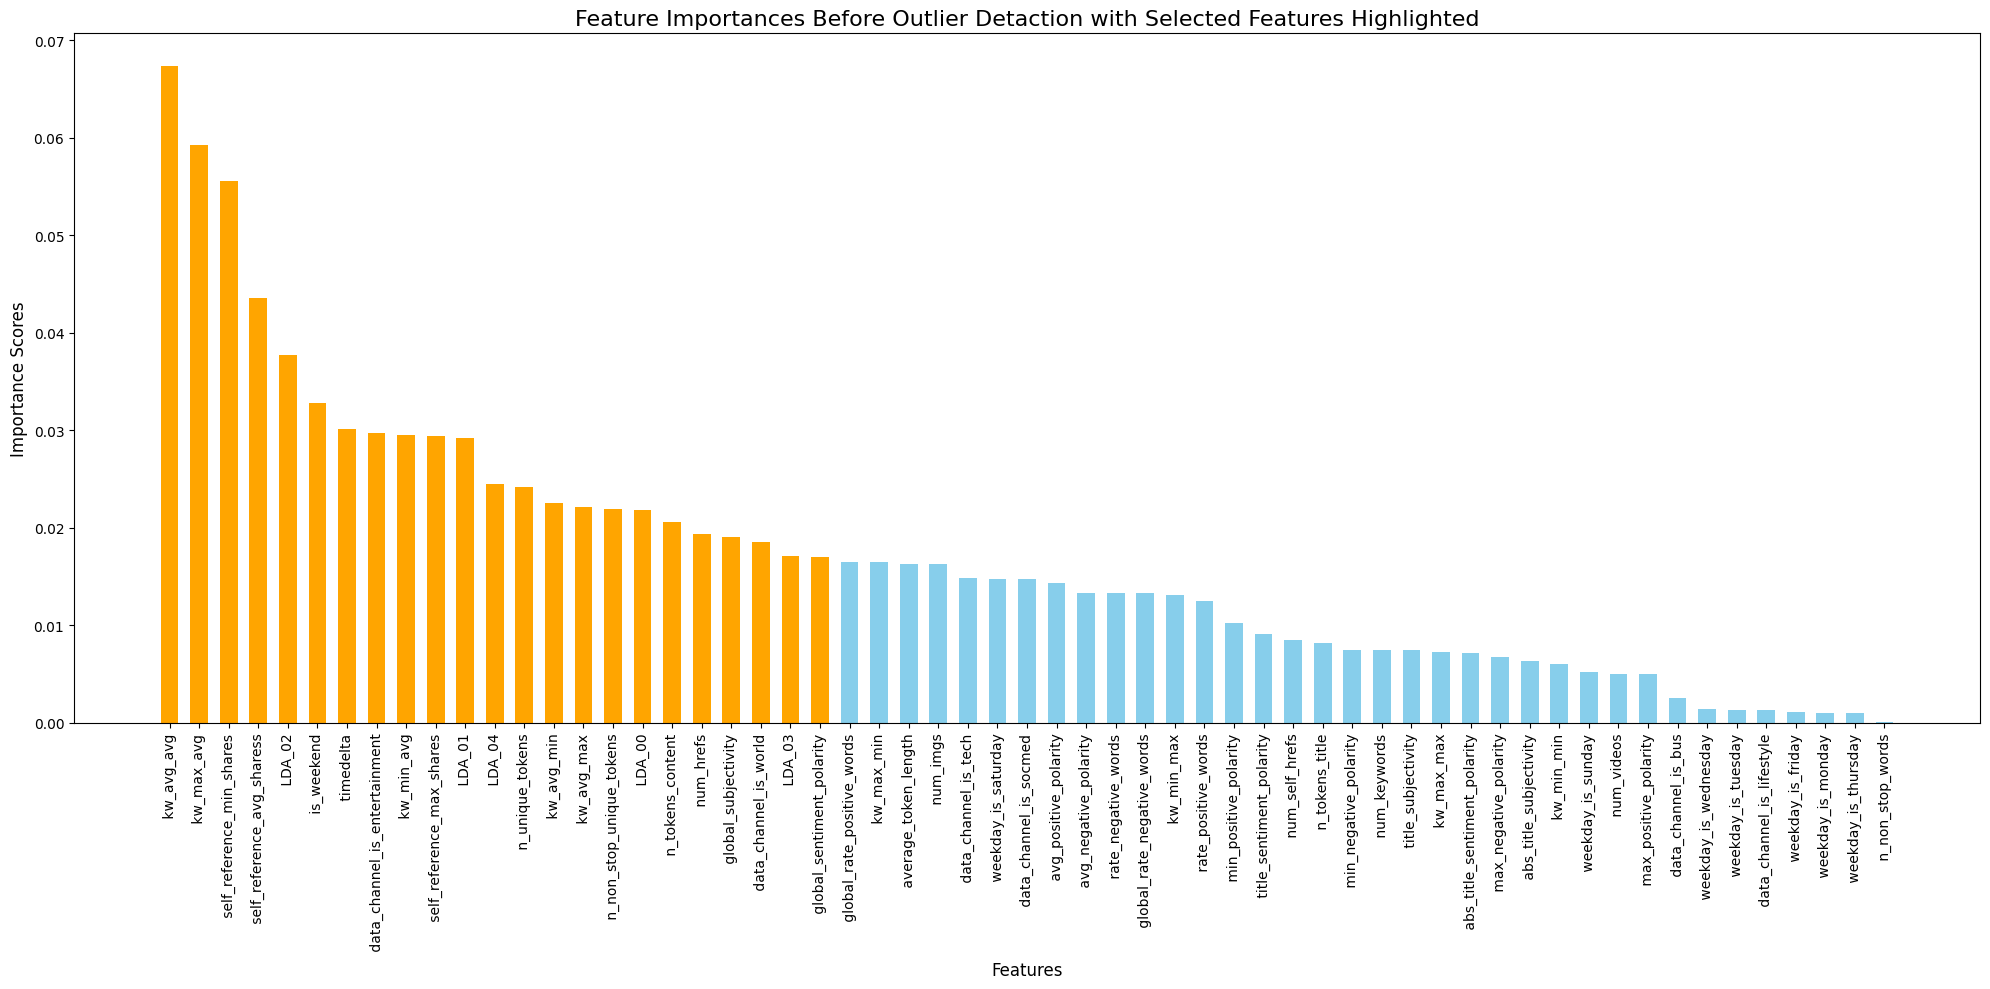

In [25]:
rf_org = grid_org.best_estimator_.named_steps['classifier']
feature_importances = rf_org.feature_importances_
# Extract the feature importances and selected feature names
feature_importances = rf_org.feature_importances_
all_features_org = x_train.columns  # Original feature names
selector_rf_org = SelectFromModel(estimator=rf_org, threshold="mean", prefit=True)
selected_features_mask = selector_rf_org.get_support()  # Boolean mask of selected features

# Create a DataFrame to compare all features and selected features
feature_comparison_df = pd.DataFrame({
    'Feature': all_features_org,
    'Importance': feature_importances,
    'Selected': selected_features_mask  # True for selected features, False otherwise
})

# Sort features by importance for better visualization (optional)
feature_comparison_df = feature_comparison_df.sort_values(by='Importance', ascending=False)

# Plot all features with the selected ones highlighted
plt.figure(figsize=(20, 10))
bar_width = 0.6
x_positions = np.arange(len(feature_comparison_df))  # Positions for all features

# Plot all features
plt.bar(
    x_positions, 
    feature_comparison_df['Importance'], 
    color=np.where(feature_comparison_df['Selected'], 'orange', 'skyblue'), 
    width=bar_width, 
    label='Feature Importance'
)

# Customize the plot
plt.xticks(x_positions, feature_comparison_df['Feature'], rotation=90, fontsize=10)
plt.ylabel("Importance Scores", fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.title("Feature Importances Before Outlier Detaction with Selected Features Highlighted", fontsize=16)
plt.tight_layout()
plt.show()

### 3.2 Using Original Data Preprocessed by PCA (Dimension Reduction) to fit classifiers:

**PCA: dimension reduction (PCA)**


Explained variance ratio for the components: [0.08138679 0.06879184 0.06020028 0.05002645 0.04689199 0.04321523
 0.04233593 0.03819407 0.03542475 0.03462301]


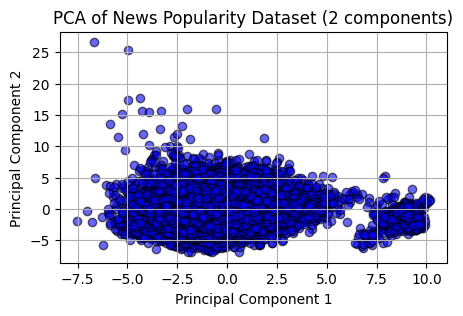

In [26]:
X = news_pop # Drop the 'url' column or any non-relevant columns

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=10)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X_scaled)

# Output the explained variance ratio
print(f"Explained variance ratio for the components: {pca.explained_variance_ratio_}")

# Plot the results
plt.figure(figsize=(5, 3))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', edgecolor='k', alpha=0.6)
plt.title("PCA of News Popularity Dataset (2 components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


After applying PCA, there even still is no clear relatioship observable. 

* Random Forest: We apply Random Forest to the original data with the PCA transformed features since its the best model observed in the previous analysis.

In [43]:
# Standardize the features since PCA is sensitive to extreme values
scaler = StandardScaler()
X_scaled_pca = scaler.fit_transform(x)

pca = PCA(n_components=15) 
X_pca = pca.fit_transform(X_scaled_pca)

# Train-test split the data for models using PCA data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Parameter grid
param_grid_rf_pca = {
    'n_estimators': [5, 10, 50, 100],  
    'max_depth': [5, 10, 20],
    'max_features': ['sqrt', 'log2']}

grid_rf_pca = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf_pca, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_rf_pca.fit(X_train_pca, y_train_pca)

# Output the best parameters and scores
print("Best Parameters:", grid_rf_pca.best_params_)
print("Best Cross-Validation Accuracy:", grid_rf_pca.best_score_)

print("\n=== Evaluation: Random Forest with PCA Data ===")

test_score = grid_rf_pca.score(X_test_pca, y_test_pca)
print("Test Accuracy:", test_score)

y_test_pred_rf_pca = grid_rf_pca.best_estimator_.predict(X_test_pca)

# Confusion Matrix
print("Confusion matrix:\n{}".format(confusion_matrix(y_test_pca, y_test_pred_rf_pca)))

# Generate a classification report
print("\n=== Classification Report ===")
print(classification_report(y_test_pca, y_test_pred_rf_pca))

# Micro-average precision, recall
micro_precision = precision_score(y_test, y_test_pred_rf_pca, average='micro')
micro_recall = recall_score(y_test, y_test_pred_rf_pca, average='micro')

print("Micro-average Precision: {:.4f}".format(micro_precision))
print("Micro-average Recall: {:.4f}".format(micro_recall))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.6465394923537758

=== Evaluation: Random Forest with PCA Data ===
Test Accuracy: 0.6437129524530205
Confusion matrix:
[[2036 1738]
 [1087 3068]]

=== Classification Report ===
              precision    recall  f1-score   support

 Not Popular       0.65      0.54      0.59      3774
     Popular       0.64      0.74      0.68      4155

    accuracy                           0.64      7929
   macro avg       0.65      0.64      0.64      7929
weighted avg       0.64      0.64      0.64      7929

Micro-average Precision: 0.6437
Micro-average Recall: 0.6437


* The result is generally worse than the previous random forest model using the original data.

### 3.3 Using Data without outlier by OneClassSVM (Outlier Detection) to fit classifiers:

1. LinearSVC
2. Logitic Regression
3. Random Forest

In [44]:
outlier_pipeline_SVM = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the data
    ('oneclass_svm', OneClassSVM(kernel='rbf', gamma='scale', nu=0.2))  # One-Class SVM
])

# Fit One-Class SVM on training data
outlier_pipeline_SVM.fit(x_train)

# Predict inliers and outliers (-1 = outlier, 1 = inlier) for training data
train_outlier_predictions = outlier_pipeline_SVM.predict(x_train)

# Filter out outliers from the training data
X_train_inliers_SVM = x_train[train_outlier_predictions == 1]
y_train_inliers_SVM = y_train[train_outlier_predictions == 1]

print("Result of One-Class SVM:")
print(f"Number of inliers in training data: {len(X_train_inliers_SVM)}")
print(f"Number of outliers removed from training data: {len(x_train) - len(X_train_inliers_SVM)}")

# Predict inliers and outliers (-1 = outlier, 1 = inlier) for test data
test_outlier_predictions_SVM = outlier_pipeline_SVM.predict(x_test)

# Filter out outliers from the test data
X_test_inliers_SVM = x_test[test_outlier_predictions_SVM == 1]
y_test_inliers_SVM = y_test[test_outlier_predictions_SVM == 1]

print(f"Number of inliers in test data: {len(X_test_inliers_SVM)}") 
print(f"Number of outliers removed from test data: {len(x_test) - len(X_test_inliers_SVM)}")

Result of One-Class SVM:
Number of inliers in training data: 25372
Number of outliers removed from training data: 6343
Number of inliers in test data: 6360
Number of outliers removed from test data: 1569


#### LinearSVC

In [45]:
svc_pipeline = Pipeline([
    ("Scaler", "passthrough"),  # Placeholder for scaler
    ("Classifier", LinearSVC(dual=False, max_iter=5000))  # LinearSVC
])

# Define parameter grid for GridSearchCV
param_grid = {
    "Scaler": [StandardScaler(), MinMaxScaler(), 'passthrough'],
    "Classifier__C": np.logspace(-6, 6, num=13)  # Regularization parameter
}

# Perform GridSearchCV
grid = GridSearchCV(svc_pipeline, param_grid, cv=10, n_jobs=-1)
grid.fit(X_train_inliers_SVM, y_train_inliers_SVM)

# Best parameters and best estimator
print("\nBest Parameters:", grid.best_params_)
print("Best Estimator:", grid.best_estimator_)

# Accuracy on training and test sets
print(f"Training Score (accuracy) of Best Estimator: {grid.best_score_:.4f}")
print(f"Test Score (accuracy) of Best Estimator: {grid.score(X_test_inliers_SVM, y_test_inliers_SVM):.4f}")

best_estimator_SVC = grid.best_estimator_.fit(X_train_inliers_SVM, y_train_inliers_SVM)

# Confusion Matrix and Classification Report on cleaned test data
print("\n=== Evaluation: LinearSVC without outliers by OneClassSVM===")
print("Confusion matrix:\n", confusion_matrix(y_test_inliers_SVM, best_estimator_SVC.predict(X_test_inliers_SVM)))
print("Classification report:\n", classification_report(y_test_inliers_SVM, best_estimator_SVC.predict(X_test_inliers_SVM)))

# Macro-average Precision, Recall & F1-score
micro_precision = precision_score(y_test_inliers_SVM, best_estimator_SVC.predict(X_test_inliers_SVM), average='micro')
micro_recall = recall_score(y_test_inliers_SVM, best_estimator_SVC.predict(X_test_inliers_SVM), average='micro')
print(f"Micro-average Precision: {micro_precision:.4f}")
print(f"Micro-average Recall: {micro_recall:.4f}")



Best Parameters: {'Classifier__C': 0.01, 'Scaler': StandardScaler()}
Best Estimator: Pipeline(steps=[('Scaler', StandardScaler()),
                ('Classifier', LinearSVC(C=0.01, dual=False, max_iter=5000))])
Training Score (accuracy) of Best Estimator: 0.6577
Test Score (accuracy) of Best Estimator: 0.6528

=== Evaluation: LinearSVC without outliers by OneClassSVM===
Confusion matrix:
 [[2016 1148]
 [1060 2136]]
Classification report:
               precision    recall  f1-score   support

 Not Popular       0.66      0.64      0.65      3164
     Popular       0.65      0.67      0.66      3196

    accuracy                           0.65      6360
   macro avg       0.65      0.65      0.65      6360
weighted avg       0.65      0.65      0.65      6360

Micro-average Precision: 0.6528
Micro-average Recall: 0.6528


Possible reasons for the marginal imrovement in performance include:

1. LinearSVC is inherently robust to certain types of noise and outliers because:
   
* It optimizes a margin-based loss, meaning that extreme data points (outliers) are less likely to influence the decision boundary significantly.
* If the outliers are evenly distributed across classes, their impact on classification performance diminishes.

2. One-Class SVM Detection
The One-Class SVM might not have effectively detected meaningful or impactful outliers due to:

* Poor parameter choices for gamma or nu, leading to detection of data points that do not strongly differ from inliers.
* Limited ability of the RBF kernel to capture complex patterns in this dataset.

3. Data Characteristics
The dataset's feature space or label distribution might already be balanced and robust against the removal of a few extreme points.
If outliers are not highly distinct from the majority of the data, their removal might not lead to a significant improvement.

#### Logistic Regression

In [46]:
# Train Logistic Regression on cleaned training data

logreg_pipeline = make_pipeline(StandardScaler(), LogisticRegression(dual=False, solver='saga', max_iter=5000))

logreg_param_grid = {'standardscaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
                     'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

logreg_grid = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=5, n_jobs=-1)
logreg_grid.fit(X_train_inliers_SVM, y_train_inliers_SVM)

# Evaluate on cleaned test data
logreg_best_model = logreg_grid.best_estimator_
y_pred_logreg_logreg_OCS = logreg_best_model.predict(X_test_inliers_SVM)

# Best parameters and best estimator
print("\nBest Parameters:", grid.best_params_)
print("Best Estimator:", grid.best_estimator_)

# Accuracy on training and test sets
print(f"Training Score (accuracy) of Best Estimator: {grid.best_score_:.4f}")
print(f"Test Score (accuracy) of Best Estimator: {grid.score(X_test_inliers_SVM, y_test_inliers_SVM):.4f}")

best_estimator_SVC = grid.best_estimator_.fit(X_train_inliers_SVM, y_train_inliers_SVM)

# Confusion Matrix and Classification Report on cleaned test data
print("\n=== Evaluation: LogisticRegressor without outliers by OneClassSVM ===")
print("Confusion matrix:\n", confusion_matrix(y_test_inliers_SVM, y_pred_logreg_logreg_OCS))
print("Classification report:\n", classification_report(y_test_inliers_SVM, y_pred_logreg_logreg_OCS))

# Macro-average Precision, Recall & F1-score
micro_precision = precision_score(y_test_inliers_SVM, y_pred_logreg_logreg_OCS, average='micro')
micro_recall = recall_score(y_test_inliers_SVM, y_pred_logreg_logreg_OCS, average='micro')
print(f"Micro-average Precision: {micro_precision:.4f}")
print(f"Micro-average Recall: {micro_recall:.4f}")


Best Parameters: {'Classifier__C': 0.01, 'Scaler': StandardScaler()}
Best Estimator: Pipeline(steps=[('Scaler', StandardScaler()),
                ('Classifier', LinearSVC(C=0.01, dual=False, max_iter=5000))])
Training Score (accuracy) of Best Estimator: 0.6577
Test Score (accuracy) of Best Estimator: 0.6528

=== Evaluation: LogisticRegressor without outliers by OneClassSVM ===
Confusion matrix:
 [[1997 1167]
 [1048 2148]]
Classification report:
               precision    recall  f1-score   support

 Not Popular       0.66      0.63      0.64      3164
     Popular       0.65      0.67      0.66      3196

    accuracy                           0.65      6360
   macro avg       0.65      0.65      0.65      6360
weighted avg       0.65      0.65      0.65      6360

Micro-average Precision: 0.6517
Micro-average Recall: 0.6517


The minimal improvement in the performance of the logistic regression model after outlier detection can be explained by several reasons:

###### 2. **Balanced Impact of Outliers Across Classes**
   - If the outliers are distributed evenly across the classes or the feature space, their impact on the decision boundary may cancel out, resulting in similar performance before and after removal.

###### 3. **Robustness of Logistic Regression**
   - Logistic regression is generally robust to mild outliers because it optimizes a convex loss function (log-loss). Unlike algorithms sensitive to extreme values (e.g., linear regression with mean squared error), logistic regression may not be significantly affected unless the outliers are severe and numerous.

###### 4. **Dataset Size and Outlier Proportion**
   - If the dataset is large relative to the number of outliers, removing them would have a negligible impact. For example, in your case, the dataset sizes (7929 before and 7062 after outlier removal) indicate that only a small fraction of data points were removed (approximately 11%). This small change in data may not significantly alter the decision boundary or performance metrics.

###### 5. **Model's Bias-Variance Tradeoff**
   - Regularization techniques in logistic regression, such as L1 or L2 penalties, inherently control for overfitting and mitigate the effect of outliers by reducing the influence of extreme coefficients. If the model was already regularized, the outliers might have had minimal impact.

###### 6. **Evaluation Metrics Sensitivity**
   - Metrics like accuracy, precision, recall, and F1-score might not be sensitive enough to small changes, especially in a balanced dataset. Minor improvements in the confusion matrix may not translate to noticeable changes in these metrics.

###### 7. **Nature of the Outliers**
   - If the removed outliers were not in regions critical for classification (e.g., near the decision boundary), their removal would not improve performance significantly. Outliers far from the boundary or in low-density regions typically contribute little to the model.

###### 8. **Overlapping Classes**
   - If the two classes have significant overlap, the decision boundary would remain similar even after outlier removal, as the outliers would not meaningfully reduce the class overlap.

In summary, the combination of a robust model, a small proportion of outliers, and possibly evenly distributed or non-critical outliers likely resulted in the observed minimal improvement in the model's performance.

#### Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score

# Step 3: Perform GridSearchCV on the cleaned training data
grid_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_rf.fit(X_train_inliers_SVM, y_train_inliers_SVM)

# Accuracy Scores
print("\n=== RandomForestClassifier Without Outliers (Cleaned Data) ===")
print("Best Parameters:", grid_rf.best_params_)
print("Best Cross-Validation Score:", grid_rf.best_score_)

test_score = grid_rf.score(X_test_inliers_SVM, y_test_inliers_SVM)
print(f"Test Accuracy (After Isolation Forest): {test_score:.4f}")

# Step 5: Evaluate on Cleaned Test Data
rf_best_model = grid_rf.best_estimator_

# Predictions on cleaned test data
y_pred_rf_cleaned = rf_best_model.predict(X_test_inliers_SVM)

# Evaluation Metrics
print("\n=== Evaluation: RandomForestClassifier Without Outliers by OneClassSVM ===")
print("Confusion Matrix:\n", confusion_matrix(y_test_inliers_SVM, y_pred_rf_cleaned))
print("Classification Report:\n", classification_report(y_test_inliers_SVM, y_pred_rf_cleaned))

# Micro-average Precision and Recall
micro_precision_rf = precision_score(y_test_inliers_SVM, y_pred_rf_cleaned, average='micro')
micro_recall_rf = recall_score(y_test_inliers_SVM, y_pred_rf_cleaned, average='micro')
print(f"Micro-average Precision: {micro_precision_rf:.4f}")
print(f"Micro-average Recall: {micro_recall_rf:.4f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits

=== RandomForestClassifier Without Outliers (Cleaned Data) ===
Best Parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__n_estimators': 100}
Best Cross-Validation Score: 0.6684138474712191
Test Accuracy (After Isolation Forest): 0.6681

=== Evaluation: RandomForestClassifier Without Outliers by OneClassSVM ===
Confusion Matrix:
 [[1953 1211]
 [ 900 2296]]
Classification Report:
               precision    recall  f1-score   support

 Not Popular       0.68      0.62      0.65      3164
     Popular       0.65      0.72      0.69      3196

    accuracy                           0.67      6360
   macro avg       0.67      0.67      0.67      6360
weighted avg       0.67      0.67      0.67      6360

Micro-average Precision: 0.6681
Micro-average Recall: 0.6681


### 3.4 Using Data without outlier by Isolation Forest (Outlier Detection) to fit classifiers:
1. LinearSVC
2. Logitic Regression
3. Random Forest

In [50]:
iso_forest = IsolationForest(contamination= 0.2, random_state=42)
outlier_flags_train = iso_forest.fit_predict(x_train)  # Train data: -1 for outliers, 1 for inliers

# Remove outliers from the training data
inlier_indices_train = np.where(outlier_flags_train == 1)[0]
X_train_cleaned = x_train.iloc[inlier_indices_train]
y_train_cleaned = y_train.iloc[inlier_indices_train]

print("Result of Isolation Forest (Outlier Detection):")
print(f"Number of inliers in training data: {len(X_train_cleaned)}")
print(f"Number of outliers removed from training data: {len(x_train) - len(X_train_cleaned)}")

# Detect and remove outliers from the test data
outlier_flags_test = iso_forest.predict(x_test)  # Test data: -1 for outliers, 1 for inliers
inlier_indices_test = np.where(outlier_flags_test == 1)[0]
X_test_cleaned = x_test.iloc[inlier_indices_test]
y_test_cleaned = y_test.iloc[inlier_indices_test]


print(f"Training Data: {len(X_train_cleaned)} inliers, {len(x_train) - len(X_train_cleaned)} outliers removed.")
print(f"Test Data: {len(X_test_cleaned)} inliers, {len(x_test) - len(X_test_cleaned)} outliers removed.")

Result of Isolation Forest (Outlier Detection):
Number of inliers in training data: 25372
Number of outliers removed from training data: 6343
Training Data: 25372 inliers, 6343 outliers removed.
Test Data: 6316 inliers, 1613 outliers removed.


#### Linear SVC Using Data without outlier by Isolation Forest

In [33]:
# Train LinearSVC on cleaned training data by isolation Forest
svc_pipeline = make_pipeline(StandardScaler(), LinearSVC(dual=False, max_iter=5000))
svc_param_grid = {'standardscaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
                  'linearsvc__C': [0.01, 0.1, 1, 10, 100]}
svc_grid = GridSearchCV(svc_pipeline, svc_param_grid, cv=5, n_jobs=-1)
svc_grid.fit(X_train_cleaned, y_train_cleaned)

# Evaluate on original and cleaned test data
svc_best_model = svc_grid.best_estimator_
y_pred_lsvc_IF = svc_best_model.predict(X_test_cleaned)

print("\n=== Evaluation: LinearSVC without outliers by Isolation Forest ===")

# Accuracy Scores
print("Best Parameters:", svc_grid.best_params_)
print("Best Cross-Validation Score:", svc_grid.best_score_)

test_score = svc_grid.score(X_test_cleaned, y_test_cleaned)
print(f"Test Accuracy (After Isolation Forest): {test_score:.4f}")

print("Confusion Matrix:\n", confusion_matrix(y_test_cleaned, y_pred_lsvc_IF ))
print("Classification Report:\n", classification_report(y_test_cleaned, y_pred_lsvc_IF ))

# Micro-average Precision and Recall
micro_precision_rf = precision_score(y_test_cleaned, y_pred_lsvc_IF , average='micro')
micro_recall_rf = recall_score(y_test_cleaned, y_pred_lsvc_IF , average='micro')
print(f"Micro-average Precision: {micro_precision_rf:.4f}")
print(f"Micro-average Recall: {micro_recall_rf:.4f}")


=== Evaluation: LinearSVC without outliers by Isolation Forest ===
Best Parameters: {'linearsvc__C': 1, 'standardscaler': MinMaxScaler()}
Best Cross-Validation Score: 0.6535948552555187
Test Accuracy (After Isolation Forest): 0.6533
Confusion Matrix:
 [[2030 1122]
 [1068 2096]]
Classification Report:
               precision    recall  f1-score   support

 Not Popular       0.66      0.64      0.65      3152
     Popular       0.65      0.66      0.66      3164

    accuracy                           0.65      6316
   macro avg       0.65      0.65      0.65      6316
weighted avg       0.65      0.65      0.65      6316

Micro-average Precision: 0.6533
Micro-average Recall: 0.6533


#### LogisticRegressor Using Data without outlier by Isolation Forest

In [40]:
# Train Logistic Regression on cleaned training data by isolation forest
logreg_pipeline = make_pipeline(StandardScaler(), LogisticRegression(dual=False, solver='saga', max_iter=5000))
logreg_param_grid = {'standardscaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
                     'logisticregression__C': [0.01, 0.1, 1, 10, 100]}
logreg_grid = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=5, n_jobs=-1)
logreg_grid.fit(X_train_cleaned, y_train_cleaned)

# Evaluate on original and cleaned test data
logreg_best_model = logreg_grid.best_estimator_
y_pred_logreg_cleaned = logreg_best_model.predict(X_test_cleaned)


print("\n=== Evaluation: Logistic Regression without outliers by Isolation Forest ===")

# Accuracy Scores
print("Best Parameters:", logreg_grid.best_params_)
print("Best Cross-Validation Score:", logreg_grid.best_score_)

test_score = svc_grid.score(X_test_cleaned, y_test_cleaned)
print(f"Test Accuracy (After Isolation Forest): {test_score:.4f}")

print("Confusion Matrix:\n", confusion_matrix(y_test_cleaned, y_pred_logreg_cleaned))
print("Classification Report:\n", classification_report(y_test_cleaned, y_pred_logreg_cleaned))

# Micro-average Precision and Recall
micro_precision_rf = precision_score(y_test_cleaned, y_pred_logreg_cleaned , average='micro')
micro_recall_rf = recall_score(y_test_cleaned, y_pred_logreg_cleaned , average='micro')
print(f"Micro-average Precision: {micro_precision_rf:.4f}")
print(f"Micro-average Recall: {micro_recall_rf:.4f}")


=== Evaluation: Logistic Regression without outliers by Isolation Forest ===
Best Parameters: {'logisticregression__C': 0.01, 'standardscaler': StandardScaler()}
Best Cross-Validation Score: 0.6541466725953426
Test Accuracy (After Isolation Forest): 0.6533
Confusion Matrix:
 [[2021 1131]
 [1067 2097]]
Classification Report:
               precision    recall  f1-score   support

 Not Popular       0.65      0.64      0.65      3152
     Popular       0.65      0.66      0.66      3164

    accuracy                           0.65      6316
   macro avg       0.65      0.65      0.65      6316
weighted avg       0.65      0.65      0.65      6316

Micro-average Precision: 0.6520
Micro-average Recall: 0.6520


#### Random Forest Using Data without outlier by Isolation Forest

In [51]:
grid_org_IF = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_org_IF.fit(X_train_cleaned, y_train_cleaned)

# Best Parameters 
print("\n=== RandomForestClassifier Without Outliers (Cleaned Data) ===")

# Predictions on Cleaned Test Data
y_test_pred_rf_IF = grid_org_IF.best_estimator_.predict(X_test_cleaned)

# Evaluation
print("\n=== Evaluation: RandomForestClassifier Without Outliers by Isolation Forest ===")

# Accuracy Scores
print("Best Parameters:", grid_org_IF.best_params_)
print("Best Cross-Validation Accuracy:", grid_org_IF.best_score_)
test_score = grid_org_IF.score(X_test_cleaned, y_test_cleaned)
print(f"Test Accuracy (After Isolation Forest): {test_score:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test_cleaned, y_test_pred_rf_IF))
print("Classification Report:\n", classification_report(y_test_cleaned, y_test_pred_rf_IF))


# Micro-average Precision and Recall
micro_precision_clean = precision_score(y_test_cleaned, y_test_pred_rf_IF, average='micro')
micro_recall_clean = recall_score(y_test_cleaned, y_test_pred_rf_IF, average='micro')
print(f"Micro-average Precision (Cleaned Test Data): {micro_precision_clean:.4f}")
print(f"Micro-average Recall (Cleaned Test Data): {micro_recall_clean:.4f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits

=== RandomForestClassifier Without Outliers (Cleaned Data) ===

=== Evaluation: RandomForestClassifier Without Outliers by Isolation Forest ===
Best Parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__n_estimators': 100}
Best Cross-Validation Accuracy: 0.6649062097702767
Test Accuracy (After Isolation Forest): 0.6650
Confusion Matrix:
 [[1980 1172]
 [ 944 2220]]
Classification Report:
               precision    recall  f1-score   support

 Not Popular       0.68      0.63      0.65      3152
     Popular       0.65      0.70      0.68      3164

    accuracy                           0.66      6316
   macro avg       0.67      0.66      0.66      6316
weighted avg       0.67      0.66      0.66      6316

Micro-average Precision (Cleaned Test Data): 0.6650
Micro-average Recall (Cleaned Test Data): 0.6650


### Deeper Exploration of the Best Model: Random Forest Classifier Without Outliers by Isolation Forest

We find random forest classifier without outliers by Isolation Forest performed better gernerally. Therefore, we will dive deeper into the exploration of the model. 

**1. Balance the two classes by class_weight**

In [110]:
pipeline_rf_balance = Pipeline([
    ('scaler', 'passthrough'),
    ('classifier', RandomForestClassifier(class_weight= "balanced",random_state=42))])

grid_org_IF_balance = GridSearchCV(estimator=pipeline_rf_balance, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_org_IF_balance.fit(X_train_cleaned, y_train_cleaned)

# Best Parameters 
print("\n=== RandomForestClassifier Without Outliers (Cleaned Data) ===")

# Predictions on Cleaned Test Data
y_test_pred_rf_IF_bal = grid_org_IF_balance.best_estimator_.predict(X_test_cleaned)

# Evaluation
print("\n=== Evaluation: RandomForestClassifier Without Outliers by Isolation Forest After Balance===")

# Accuracy Scores
print("Best Parameters:", grid_org_IF_balance.best_params_)
print("Best Cross-Validation Accuracy:", grid_org_IF_balance.best_score_)
test_score = grid_org_IF_balance.score(X_test_cleaned, y_test_cleaned)
print(f"Test Accuracy (After Isolation Forest): {test_score:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test_cleaned, y_test_pred_rf_IF_bal))
print("Classification Report:\n", classification_report(y_test_cleaned, y_test_pred_rf_IF_bal))


# Micro-average Precision and Recall
micro_precision_clean = precision_score(y_test_cleaned, y_test_pred_rf_IF_bal, average='micro')
micro_recall_clean = recall_score(y_test_cleaned, y_test_pred_rf_IF_bal, average='micro')
print(f"Micro-average Precision (Cleaned Test Data): {micro_precision_clean:.4f}")
print(f"Micro-average Recall (Cleaned Test Data): {micro_recall_clean:.4f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits

=== RandomForestClassifier Without Outliers (Cleaned Data) ===

=== Evaluation: RandomForestClassifier Without Outliers by Isolation Forest After Balance===
Best Parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__n_estimators': 100}
Best Cross-Validation Accuracy: 0.664630130230228
Test Accuracy (After Isolation Forest): 0.6713
Confusion Matrix:
 [[2071 1081]
 [ 995 2169]]
Classification Report:
               precision    recall  f1-score   support

 Not Popular       0.68      0.66      0.67      3152
     Popular       0.67      0.69      0.68      3164

    accuracy                           0.67      6316
   macro avg       0.67      0.67      0.67      6316
weighted avg       0.67      0.67      0.67      6316

Micro-average Precision (Cleaned Test Data): 0.6713
Micro-average Recall (Cleaned Test Data): 0.6713


**2. Feature Importance Analysis & Feature Selection by SelectFromModel**

In [111]:
best_model = grid_org_IF_balance.best_estimator_.named_steps['classifier']
feature_importances = best_model.feature_importances_

selector = SelectFromModel(estimator=best_model, threshold="mean", prefit=True)

# Apply SelectFromModel to training and testing data
# Transform without worrying about feature names
X_train_selected = selector.transform(X_train_cleaned.values)  # Use .values to strip feature names
X_test_selected = selector.transform(X_test_cleaned.values)

# Get selected feature names using the boolean mask
selected_features = X_train_cleaned.columns[selector.get_support()]
print(f"Selected Features: {selected_features.tolist()}")

# Convert the transformed data back to a DataFrame with feature names
X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train_cleaned.index)
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test_cleaned.index)

# Display the transformed DataFrame
print("\n=== Transformed Training Data (Selected Features) ===")

Selected Features: [' timedelta', ' n_tokens_content', ' n_unique_tokens', ' n_non_stop_unique_tokens', ' num_hrefs', ' data_channel_is_entertainment', ' kw_max_min', ' kw_avg_min', ' kw_avg_max', ' kw_min_avg', ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares', ' self_reference_max_shares', ' self_reference_avg_sharess', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02', ' LDA_03', ' LDA_04', ' global_subjectivity', ' global_sentiment_polarity', ' global_rate_positive_words']

=== Transformed Training Data (Selected Features) ===


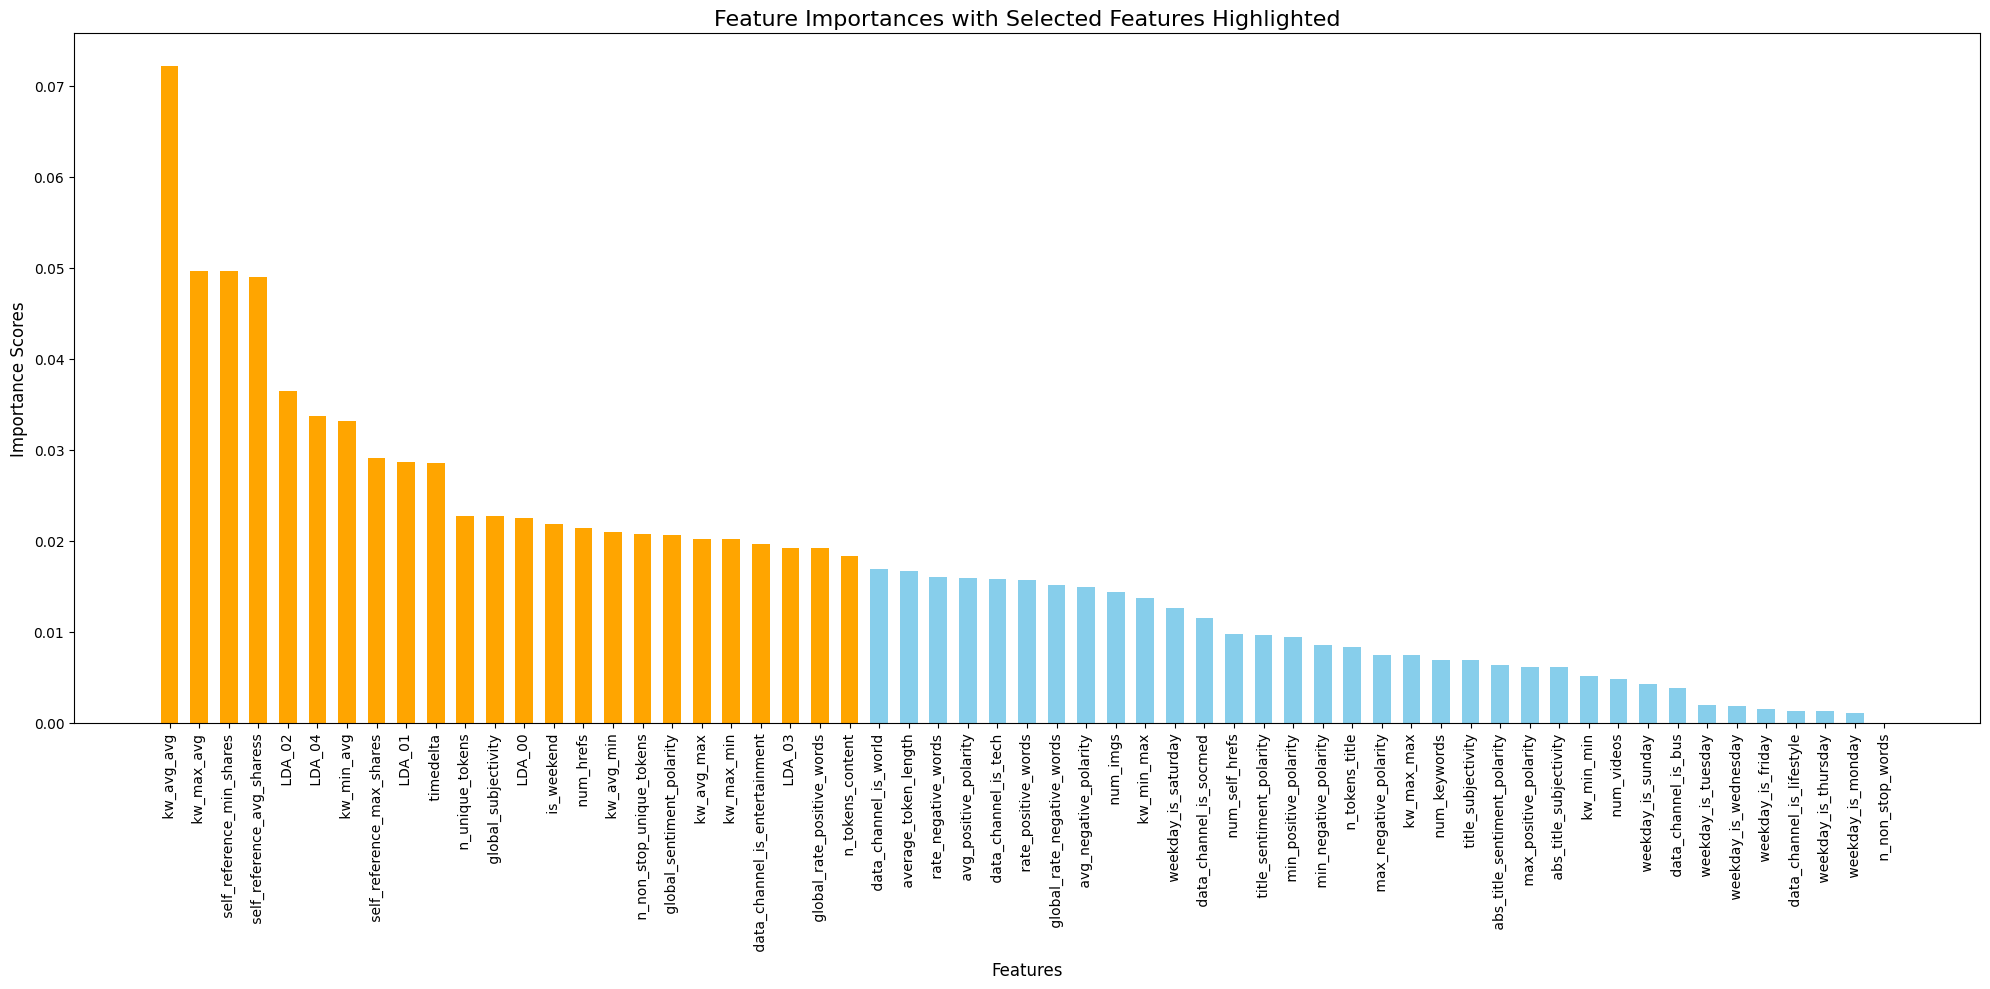

In [112]:
# Extract the feature importances and selected feature names
feature_importances = best_model.feature_importances_
all_features = X_train_cleaned.columns  # Original feature names
selected_features_mask = selector.get_support()  # Boolean mask of selected features

# Create a DataFrame to compare all features and selected features
feature_comparison_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances,
    'Selected': selected_features_mask  # True for selected features, False otherwise
})

# Sort features by importance for better visualization (optional)
feature_comparison_df = feature_comparison_df.sort_values(by='Importance', ascending=False)

# Plot all features with the selected ones highlighted
plt.figure(figsize=(20, 10))
bar_width = 0.6
x_positions = np.arange(len(feature_comparison_df))  # Positions for all features

# Plot all features
plt.bar(
    x_positions, 
    feature_comparison_df['Importance'], 
    color=np.where(feature_comparison_df['Selected'], 'orange', 'skyblue'), 
    width=bar_width, 
    label='Feature Importance'
)

# Customize the plot
plt.xticks(x_positions, feature_comparison_df['Feature'], rotation=90, fontsize=10)
plt.ylabel("Importance Scores", fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.title("Feature Importances with Selected Features Highlighted", fontsize=16)
plt.tight_layout()
plt.show()


**3. Fit the random forest classifier using the selected features by SelectFromModel**

In [64]:
# Step 4: Evaluate the model on the selected features (optional step)
best_model.fit(X_train_selected, y_train_cleaned)
y_test_pred_selected_SFM = best_model.predict(X_test_selected)

print("\n=== Evaluation After SelectFromModel ===")
selected_test_score = best_model.score(X_test_selected, y_test_cleaned)
print(f"Test Accuracy (Selected Features): {selected_test_score:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test_cleaned, y_test_pred_selected_SFM))
print("Classification Report:\n", classification_report(y_test_cleaned, y_test_pred_selected_SFM))

micro_precision_selected = precision_score(y_test_cleaned, y_test_pred_selected_SFM, average='micro')
micro_recall_selected = recall_score(y_test_cleaned, y_test_pred_selected_SFM, average='micro')
print(f"Micro-average Precision (Selected Features): {micro_precision_selected:.4f}")
print(f"Micro-average Recall (Selected Features): {micro_recall_selected:.4f}")



=== Evaluation After SelectFromModel ===
Test Accuracy (Selected Features): 0.6643
Confusion Matrix:
 [[2047 1105]
 [1015 2149]]
Classification Report:
               precision    recall  f1-score   support

 Not Popular       0.67      0.65      0.66      3152
     Popular       0.66      0.68      0.67      3164

    accuracy                           0.66      6316
   macro avg       0.66      0.66      0.66      6316
weighted avg       0.66      0.66      0.66      6316

Micro-average Precision (Selected Features): 0.6643
Micro-average Recall (Selected Features): 0.6643


**4. Find new relationship in the selected features by clustering:**

In [86]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use the selected features for clustering
x_dbscan_features = X_train_selected  # Assuming training data is used for clustering

# Scale the data using MinMaxScaler
scaler_db = MinMaxScaler()
x_db_scaled = scaler_db.fit_transform(x_dbscan_features)

# Define the range of epsilon values for DBSCAN
db_eps_values = np.arange(0.6, 0.7, 0.02)

# Iterate over epsilon values and analyze the results
for eps in db_eps_values:
    print(f"\nTesting DBSCAN with eps={eps}")
    
    # Initialize and fit DBSCAN
    dbscan_cluster = DBSCAN(eps=eps, min_samples=400)  # Adjust min_samples if necessary
    clusters_db = dbscan_cluster.fit_predict(x_db_scaled)
    
    # Add the cluster labels temporarily for analysis
    x_dbscan_features['Cluster'] = clusters_db

    # Analyze the clustering results
    n_clusters_db = len(set(clusters_db)) - (1 if -1 in clusters_db else 0)  # Number of clusters
    n_noise_db = list(clusters_db).count(-1)  # Number of noise points

    print(f"Number of clusters: {n_clusters_db}")
    print(f"Number of noise points: {n_noise_db}")

    # Optional: Calculate and display cluster sizes
    cluster_sizes_db = pd.Series(clusters_db).value_counts()
    print("Cluster sizes:")
    print(cluster_sizes_db)



Testing DBSCAN with eps=0.6
Number of clusters: 3
Number of noise points: 2114
Cluster sizes:
 0    18665
 1     3930
-1     2114
 2      663
Name: count, dtype: int64

Testing DBSCAN with eps=0.62
Number of clusters: 4
Number of noise points: 1563
Cluster sizes:
 0    18707
 1     3968
-1     1563
 2      707
 3      427
Name: count, dtype: int64

Testing DBSCAN with eps=0.64
Number of clusters: 3
Number of noise points: 1356
Cluster sizes:
 0    18741
 1     3986
-1     1356
 2     1289
Name: count, dtype: int64

Testing DBSCAN with eps=0.66
Number of clusters: 3
Number of noise points: 1265
Cluster sizes:
 0    18757
 1     3994
 2     1356
-1     1265
Name: count, dtype: int64

Testing DBSCAN with eps=0.68
Number of clusters: 3
Number of noise points: 1204
Cluster sizes:
 0    18766
 1     3997
 2     1405
-1     1204
Name: count, dtype: int64


We try to use for loop to do grid search for the best DBSCAN parameters below, and we use the result to adjust the above code.

## MISSION 2
#### Clustering articles on the types of words, topics, and general sentiment (provided as features) and examining if these clusters correspond with article popularity.

In [87]:
# Select all rows for the adjusted columns (columns 1-51 based on your description)
features = news_pop.iloc[:, [1, 2, 3, 4, 5, 10, 11, 12, 13, 14, 15, 16, 17, 
                                      18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 38, 
                                      39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 
                                      50, 51]]

news_pop['pop_label'] = news_pop[' shares'].apply(lambda x: 1 if x > 1400 else 0)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


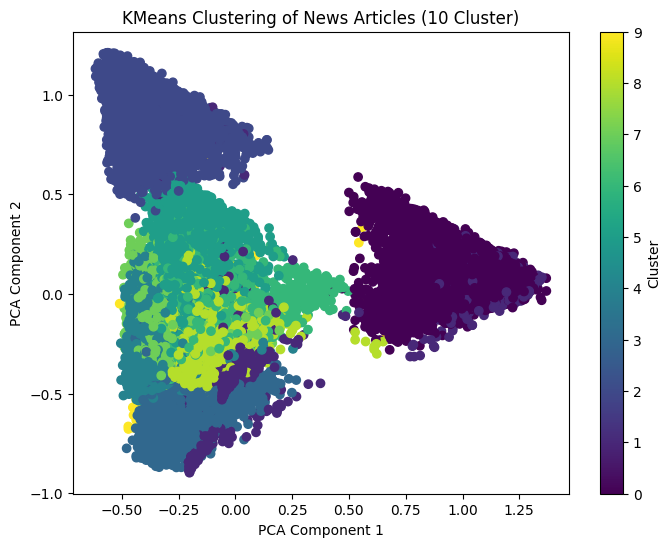

In [ ]:
# Standardize the features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=42)
news_pop['cluster'] = kmeans.fit_predict(features_scaled)

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(features_scaled)

# Visualize 2D
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=news_pop['cluster'], cmap='viridis')
plt.title('KMeans Clustering of News Articles (10 Cluster)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'news_pop' is your DataFrame and 'cluster' column has been added
# Add the 'pop_label' (popularity) to the clustering result

# Compare clusters with popularity
cluster_popularity_comparison = news_pop.groupby('cluster')['pop_label'].mean()

# Print the comparison of clusters with popularity
print("Comparison of Clusters with Popularity:")
print(cluster_popularity_comparison)

Comparison of Clusters with Popularity:
cluster
0    0.342917
1    0.548003
2    0.592901
3    0.370463
4    0.509904
5    0.568116
6    0.716989
7    0.460864
8    0.617034
9    0.497704
Name: pop_label, dtype: float64


In [90]:
# Calculate the counts of 'pop_label' in each cluster
cluster_popularity_counts = news_pop.groupby('cluster')['pop_label'].value_counts()

# Display the distribution of popularity within each cluster
print("Cluster Purity (Distribution of Popularity within Each Cluster):")
print(cluster_popularity_counts)


Cluster Purity (Distribution of Popularity within Each Cluster):
cluster  pop_label
0        0            5348
         1            2791
1        1             645
         0             532
2        1            4343
         0            2982
3        0            4024
         1            2368
4        1            1493
         0            1435
5        1            1176
         0             894
6        1            1629
         0             643
7        0            1784
         1            1525
8        1            3050
         0            1893
9        0             547
         1             542
Name: count, dtype: int64


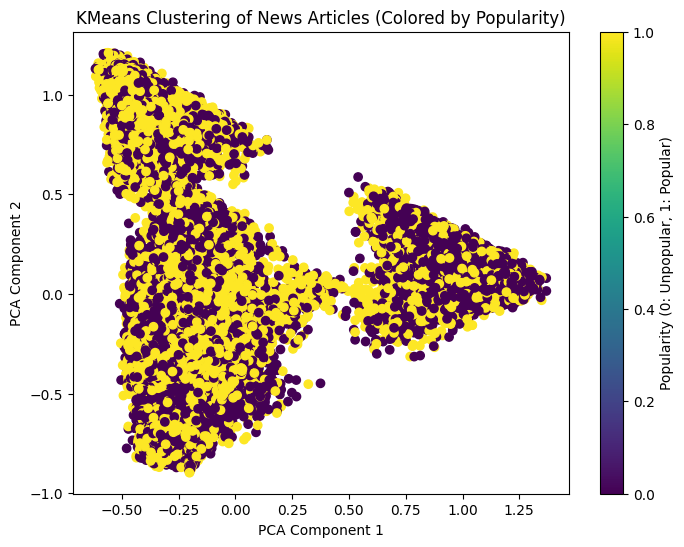

In [91]:
# Visualize the clusters and color them by popularity
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=news_pop['pop_label'], cmap='viridis')
plt.title('KMeans Clustering of News Articles (Colored by Popularity)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Popularity (0: Unpopular, 1: Popular)')
plt.show()


Cluster Centroids:
     n_tokens_title   n_tokens_content   n_unique_tokens   n_non_stop_words  \
0          0.411540           0.072593          0.000716           0.000925   
1          0.395087           0.044827          0.000854           0.000960   
2          0.396256           0.069347          0.000758           0.000958   
3          0.395371           0.067608          0.000776           0.000959   
4          0.426269           0.069250          0.000782           0.000959   
5          0.369163           0.074049          0.000754           0.000958   
6          0.363465           0.072492          0.000766           0.000960   
7          0.378028           0.036527          0.000929           0.000960   
8          0.388049           0.065815          0.000758           0.000959   
9          0.409206           0.070442          0.000733           0.000939   
10         0.439130           0.075879          0.000782           0.000960   
11         0.383951           0.0

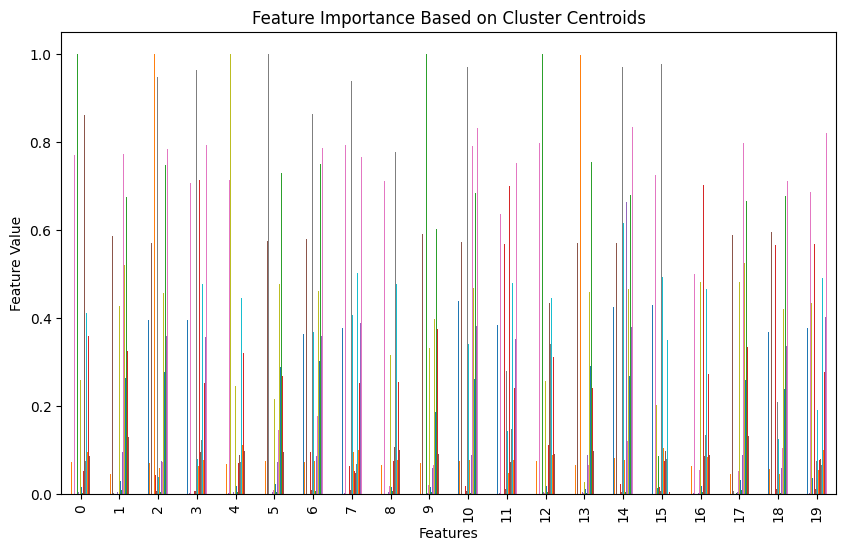

In [106]:
# Get the centroids of the clusters
centroids = kmeans.cluster_centers_

# Create a DataFrame to display the centroids
centroid_df = pd.DataFrame(centroids, columns=features.columns)

# Display the centroids
print("Cluster Centroids:")
print(centroid_df)

# Visualize the centroids for better interpretation
centroid_df.plot(kind='bar', figsize=(10, 6),legend=False)
plt.title('Feature Importance Based on Cluster Centroids')
plt.ylabel('Feature Value')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


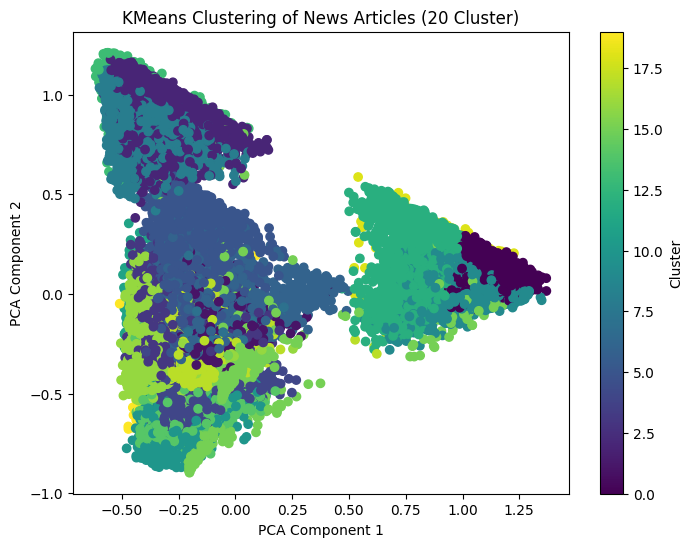

In [93]:
# Standardize the features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=20, random_state=42)
news_pop['cluster'] = kmeans.fit_predict(features_scaled)

# Optional: Reduce dimensions for visualization (using PCA for 2D)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(features_scaled)

# Visualize the clusters in a 2D plot
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=news_pop['cluster'], cmap='viridis')
plt.title('KMeans Clustering of News Articles (20 Cluster)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Compare clusters with popularity
cluster_popularity_comparison = news_pop.groupby('cluster')['pop_label'].mean()

print("Comparison of Clusters with Popularity:")
print(cluster_popularity_comparison)

Comparison of Clusters with Popularity:
cluster
0     0.294876
1     0.591739
2     0.546541
3     0.447029
4     0.348996
5     0.567121
6     0.718472
7     0.565354
8     0.639021
9     0.318524
10    0.392354
11    0.493703
12    0.435500
13    0.621861
14    0.367089
15    0.556225
16    0.519608
17    0.656428
18    0.438662
19    0.489152
Name: pop_label, dtype: float64


In [95]:
# Calculate the counts of 'pop_label' in each cluster
cluster_popularity_counts = news_pop.groupby('cluster')['pop_label'].value_counts()

# Display the distribution of popularity within each cluster
print("Cluster Purity (Distribution of Popularity within Each Cluster):")
print(cluster_popularity_counts)

Cluster Purity (Distribution of Popularity within Each Cluster):
cluster  pop_label
0        0            2078
         1             869
1        1            1232
         0             850
2        1            1920
         0            1593
3        0            1545
         1            1249
4        0            1427
         1             765
5        1            1166
         0             890
6        1            1618
         0             634
7        1             359
         0             276
8        1            2011
         0            1136
9        0            1902
         1             889
10       0            1510
         1             975
11       0             402
         1             392
12       0            1164
         1             898
13       1             421
         0             256
14       0            1100
         1             638
15       1             554
         0             442
16       1            1378
         0            127

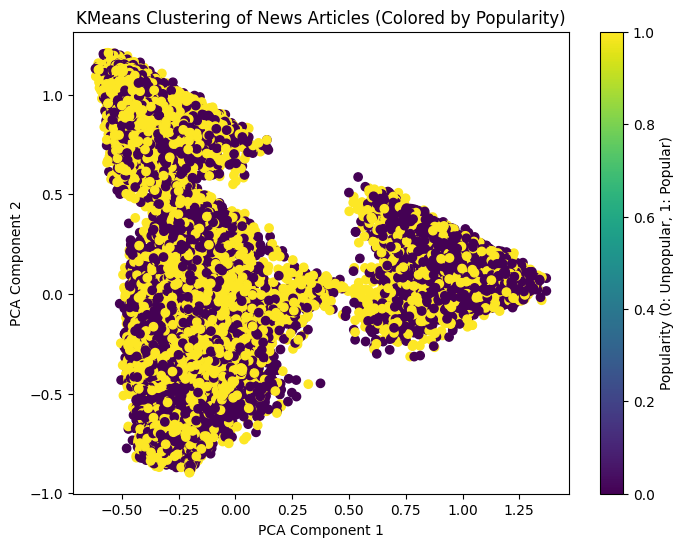

In [ ]:
# Clusters and color them by popularity
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=news_pop['pop_label'], cmap='viridis')
plt.title('KMeans Clustering of News Articles (Colored by Popularity)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Popularity (0: Unpopular, 1: Popular)')
plt.show()

Cluster Centroids:
     n_tokens_title   n_tokens_content   n_unique_tokens   n_non_stop_words  \
0          0.411540           0.072593          0.000716           0.000925   
1          0.395087           0.044827          0.000854           0.000960   
2          0.396256           0.069347          0.000758           0.000958   
3          0.395371           0.067608          0.000776           0.000959   
4          0.426269           0.069250          0.000782           0.000959   
5          0.369163           0.074049          0.000754           0.000958   
6          0.363465           0.072492          0.000766           0.000960   
7          0.378028           0.036527          0.000929           0.000960   
8          0.388049           0.065815          0.000758           0.000959   
9          0.409206           0.070442          0.000733           0.000939   
10         0.439130           0.075879          0.000782           0.000960   
11         0.383951           0.0

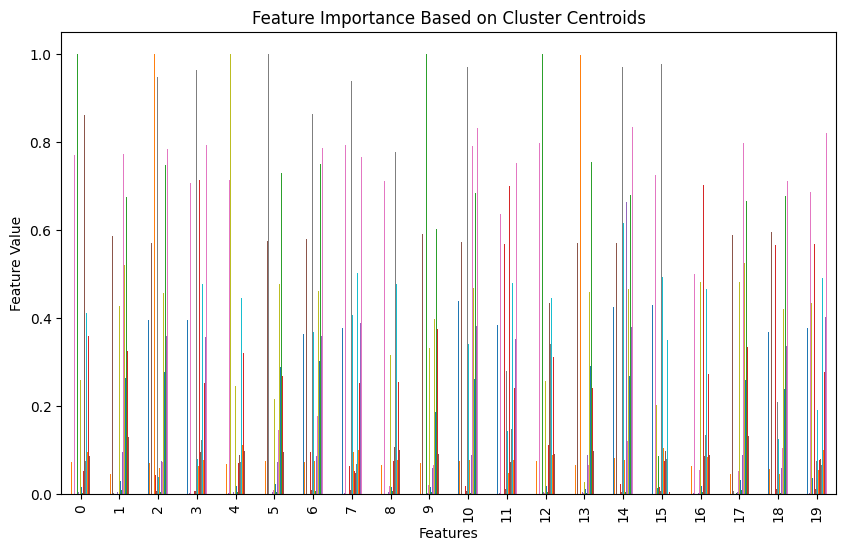

In [ ]:
# Centroids of the clusters
centroids = kmeans.cluster_centers_

centroid_df = pd.DataFrame(centroids, columns=features.columns)

# Display
print("Cluster Centroids:")
print(centroid_df)

# Visualize the centroids for better interpretation
centroid_df.plot(kind='bar', figsize=(10, 6), legend=False)
plt.title('Feature Importance Based on Cluster Centroids')
plt.ylabel('Feature Value')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.show()


Testing DBSCAN with eps=0.6


/var/folders/t0/t06xz7jx0v92cq5zx7ykzyt80000gn/T/ipykernel_28867/3889077156.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Cluster'] = clusters_dbc


Number of clusters: 14
Number of noise points: 2546
Cluster sizes:
 6     7637
 1     7178
 9     6185
 3     6028
 7     4617
-1     2546
 8     1628
 10    1546
 12     624
 2      463
 0      394
 11     242
 4      229
 5      225
 13     102
Name: count, dtype: int64


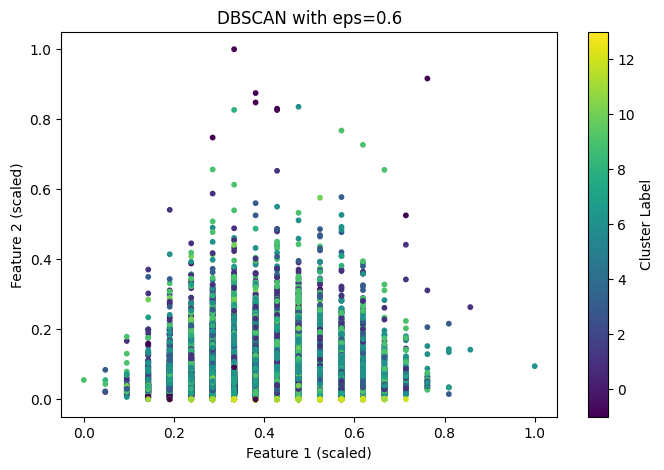


Testing DBSCAN with eps=0.62


/var/folders/t0/t06xz7jx0v92cq5zx7ykzyt80000gn/T/ipykernel_28867/3889077156.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Cluster'] = clusters_dbc


Number of clusters: 13
Number of noise points: 2087
Cluster sizes:
 0     8075
 1     7213
 8     6223
 3     6079
 6     4672
-1     2087
 7     1669
 9     1651
 11     627
 2      477
 10     247
 4      246
 5      246
 12     132
Name: count, dtype: int64


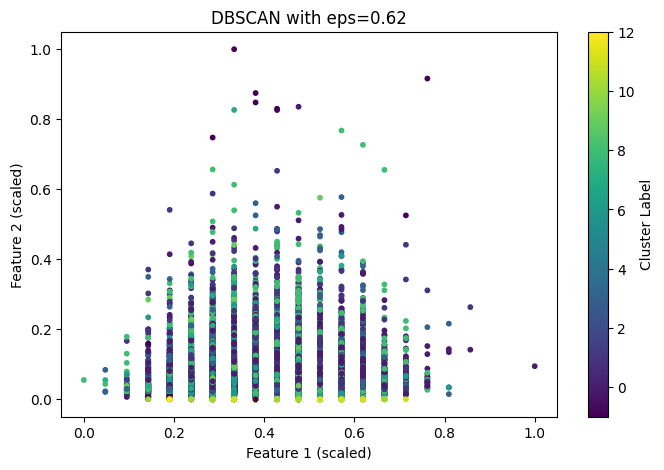


Testing DBSCAN with eps=0.64


/var/folders/t0/t06xz7jx0v92cq5zx7ykzyt80000gn/T/ipykernel_28867/3889077156.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Cluster'] = clusters_dbc


Number of clusters: 12
Number of noise points: 1580
Cluster sizes:
 0     8110
 1     7240
 7     6258
 5     6120
 3     5304
 8     1756
 6     1704
-1     1580
 10     629
 4      283
 2      261
 9      250
 11     149
Name: count, dtype: int64


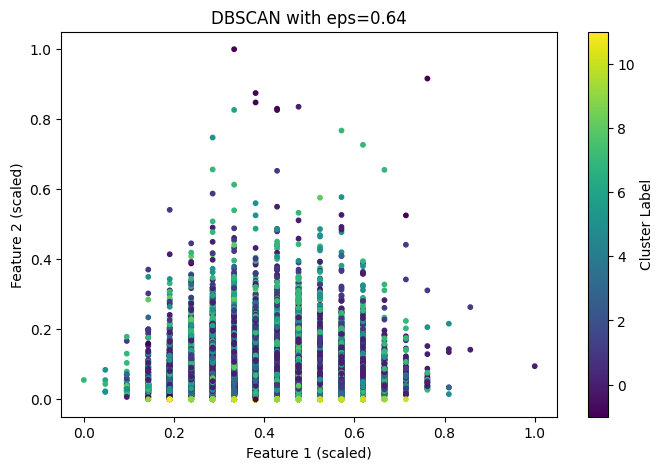


Testing DBSCAN with eps=0.66


/var/folders/t0/t06xz7jx0v92cq5zx7ykzyt80000gn/T/ipykernel_28867/3889077156.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Cluster'] = clusters_dbc


Number of clusters: 11
Number of noise points: 1160
Cluster sizes:
 0     8122
 1     7261
 4     6713
 5     6176
 3     5352
 7     1825
 6     1721
-1     1160
 9      632
 2      276
 8      251
 10     155
Name: count, dtype: int64


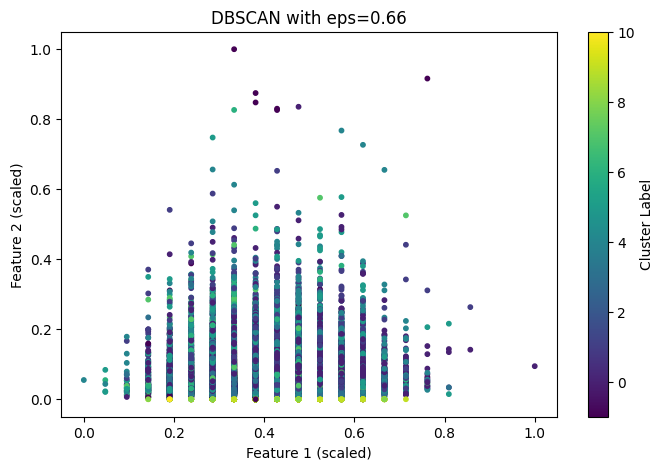


Testing DBSCAN with eps=0.68


/var/folders/t0/t06xz7jx0v92cq5zx7ykzyt80000gn/T/ipykernel_28867/3889077156.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Cluster'] = clusters_dbc


Number of clusters: 10
Number of noise points: 921
Cluster sizes:
 0    8135
 1    7279
 4    6781
 5    6191
 3    5390
 2    2030
 6    1876
-1     921
 8     633
 7     251
 9     157
Name: count, dtype: int64


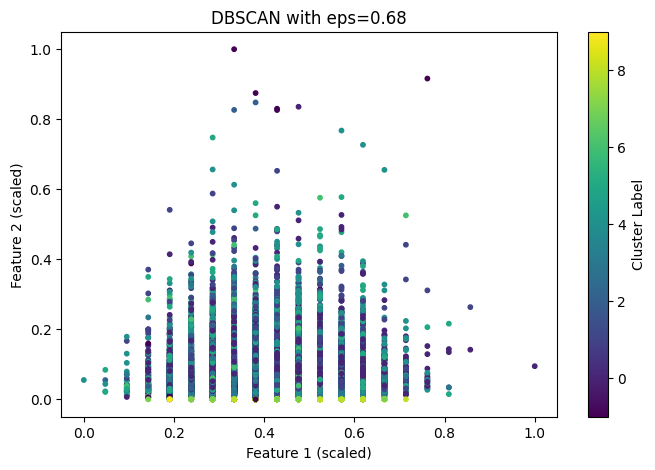

/var/folders/t0/t06xz7jx0v92cq5zx7ykzyt80000gn/T/ipykernel_28867/3889077156.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.drop(columns=['Cluster'], inplace=True)


In [114]:
from sklearn.cluster import DBSCAN

x_dbscan_features_2 = features
scaler_dbc = MinMaxScaler()
x_dbc_scaled = scaler_dbc.fit_transform(x_dbscan_features_2)

db_eps_values = np.arange(0.6,0.7,0.02)

# Iterate over eps values and analyze the results
for eps in db_eps_values:
    print(f"\nTesting DBSCAN with eps={eps}")
    dbscan_cluster_dbc = DBSCAN(eps=eps, min_samples=100)  # Adjust min_samples if necessary
    clusters_dbc = dbscan_cluster_dbc.fit_predict(x_dbc_scaled)

    # Add the cluster labels to the data temporarily
    features['Cluster'] = clusters_dbc

    # Analyze the results
    n_clusters_dbc = len(set(clusters_dbc)) - (1 if -1 in clusters_dbc else 0)
    n_noise_dbc = list(clusters_dbc).count(-1)

    print(f"Number of clusters: {n_clusters_dbc}")
    print(f"Number of noise points: {n_noise_dbc}")

    # Optional: Calculate and display cluster sizes
    cluster_sizes_dbc = pd.Series(clusters_dbc).value_counts()
    print("Cluster sizes:")
    print(cluster_sizes_dbc)

    # Optional: Plot the results (2D projection)
    plt.figure(figsize=(8, 5))
    plt.title(f"DBSCAN with eps={eps}")
    plt.scatter(x_dbc_scaled[:, 0], x_dbc_scaled[:, 1], c=clusters_dbc, cmap='viridis', s=10)
    plt.colorbar(label='Cluster Label')
    plt.xlabel("Feature 1 (scaled)")
    plt.ylabel("Feature 2 (scaled)")
    plt.show()

# Remove the temporary 'Cluster' column from your dataset
features.drop(columns=['Cluster'], inplace=True)

### ARI and NMI

In [115]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

y_db = news_pop['pop_label']
ari = adjusted_rand_score(y_db, clusters_dbc)
nmi = normalized_mutual_info_score(y_db, clusters_dbc)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

Adjusted Rand Index (ARI): 0.0174
Normalized Mutual Information (NMI): 0.0218


### Comparison of clusters with popularity

In [116]:
news_pop_db = news_pop.assign(clusters_dbc = clusters_dbc)
news_pop_db.head()

timedelta   n_tokens_title   n_tokens_content   n_unique_tokens  \
0       731.0             12.0              219.0          0.663594   
1       731.0              9.0              255.0          0.604743   
2       731.0              9.0              211.0          0.575130   
3       731.0              9.0              531.0          0.503788   
4       731.0             13.0             1072.0          0.415646   

    n_non_stop_words   n_non_stop_unique_tokens   num_hrefs   num_self_hrefs  \
0                1.0                   0.815385         4.0              2.0   
1                1.0                   0.791946         3.0              1.0   
2                1.0                   0.663866         3.0              1.0   
3                1.0                   0.665635         9.0              0.0   
4                1.0                   0.540890        19.0             19.0   

    num_imgs   num_videos  ...   max_negative_polarity   title_subjectivity  \
0        1.0          0.0  ...               -0.200000             0.500000   
1        1.0          0.0  ...               -0.100000             0.000000   
2        1.0          0.0  ...               -0.133333             0.000000   
3        1.0          0.0  ...               -0.166667             0.000000   
4       20.0          0.0  ...               -0.050000             0.454545   

    title_sentiment_polarity   abs_title_subjectivity  \
0                  -0.187500                 0.000000   
1                   0.000000                 0.500000   
2                   0.000000                 0.500000   
3                   0.000000                 0.500000   
4                   0.136364                 0.045455   

    abs_title_sentiment_polarity   shares  Cluster  pop_label  cluster  \
0                       0.187500      593       -1          0       19   
1                       0.000000      711       -1          0       11   
2                       0.000000     1500       -1          1       11   
3                       0.000000     1200       -1          0       19   
4                       0.136364      505       -1          0       13   

   clusters_dbc  
0            -1  
1             5  
2            -1  
3             4  
4             1  

[5 rows x 64 columns]

In [117]:
cluster_popularity_comparison_db = news_pop_db.groupby('clusters_dbc')['pop_label'].mean()

print("Comparison of Clusters with Popularity")
print(cluster_popularity_comparison_db)

Comparison of Clusters with Popularity
clusters_dbc
-1    0.626493
 0    0.342225
 1    0.592664
 2    0.564532
 3    0.610390
 4    0.372364
 5    0.483767
 6    0.732942
 7    0.498008
 8    0.584518
 9    0.388535
Name: pop_label, dtype: float64


### Popularity counts

In [118]:
# Calculate the counts of 'pop_label' in each cluster
cluster_popularity_counts_db = news_pop_db.groupby('clusters_dbc')['pop_label'].value_counts()

# Display the distribution of popularity within each cluster
print("Cluster Purity (Distribution of Popularity within Each Cluster):")
print(cluster_popularity_counts_db)

Cluster Purity (Distribution of Popularity within Each Cluster):
clusters_dbc  pop_label
-1            1             577
              0             344
 0            0            5351
              1            2784
 1            1            4314
              0            2965
 2            1            1146
              0             884
 3            1            3290
              0            2100
 4            0            4256
              1            2525
 5            0            3196
              1            2995
 6            1            1375
              0             501
 7            0             126
              1             125
 8            1             370
              0             263
 9            0              96
              1              61
Name: count, dtype: int64
